In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, LSTM, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import random
import matplotlib.pyplot as plt
import json
import keras.callbacks
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [2]:
import os
path = os.getcwd()+'/data/icons'

# 把图像编码成一个数组encoded[:size_last_x]，结果长短不一
def encode_icon(img, icon_size):
    size_last_x = 0
    encoded = []
    # 遍历所有列（：，y）
    for y in range(icon_size):
        # 遍历所有行（x，：）
        for x in range(icon_size):
            # 获得灰度值，0是黑，255是白，把有颜色的都加进来
            p = img.getpixel((x, y))
            # 只把有一定颜色的元素加入到encoded里。
            if img.getpixel((x, y)) < 192:
                encoded.append(x)
                # 保存size_last_x的用途在于，常常最后几列，都是偏白的元素，因此导致多个icon_size连续出现。
                # 用encoded[:size_last_x]即可保证，输出的数组，最后一个元素为有效像素，而不是标记。
                size_last_x = len(encoded)
        # 在一列遍历完了之后，在encoded中增加一个元素作为解码时恢复列元素的标记。
        encoded.append(icon_size)
#     print('size_last_x=',size_last_x)
#     print('len of encoded=',len(encoded))
#     print('the last element of encoded=',encoded[-1])
#     print('encoded=',encoded)
#     print('encoded[size_last_x]=',encoded[size_last_x-1])
#     exit()
    return encoded[:size_last_x]

# 利用icon_size的标记来解码encoded向量，返回一张像素矩阵。
def decode_icon(encoded, icon_size, rows=None, stop_token=None):
    y = 0
    for idx in encoded:
        if idx == icon_size:
            y += 1
        elif idx == icon_size + 1:
            break
        else:
            x = idx
            yield x, y

# 对数据进行合并。
# 合并方法：把每个图片对应的数组，练成一个大数组，中间用数字33做标记隔开。
def make_array(icons):
    res = []
    for icon in icons:
        res.extend(icon)
        res.append(33)
    return np.asarray(res)

def load_icons(train_size=0.90):
    icon_index = json.load(open(path+'/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = path+'/png32/%s.png' % icon['name']
        img = PIL.Image.open(img_path)
        if img.mode != 'L':
            img = img.convert('L')
        # 编码图片为一个向量，并添加到x数组
        print('encode_icon(img, 32)=',encode_icon(img, 32))
        x.append(encode_icon(img, 32))
    # x是一个数组，每个元素对应一个图片，每个元素也是一个数组。
    
    x_train, x_val = train_test_split(x, train_size=train_size)
#     print('x_train=',len(x_train))
#     print('x_train=',x_train)
#     exit()
    # 将训练数据拼成一个序列
    x_train = make_array(x_train)
    # 将验证数据拼成一个序列
    x_val = make_array(x_val)
    # 数据量((1912702,), (211903,))
    # return x_train, x_val
    #  少量数据
    return x_train[:10000], x_val[:1000]

x_train, x_test = load_icons()
x_train.shape, x_test.shape

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 29, 30, 32, 1, 2, 5, 6, 8, 9, 10, 15, 16, 21, 22, 23, 25, 26, 29, 30, 32, 1, 2, 5, 6, 9, 10, 14, 15, 16, 17, 21, 22, 25, 26, 29, 30, 32, 1, 2, 6, 7, 14, 15, 16, 17, 24, 25, 29, 30, 32, 0, 1, 6, 7, 14, 15, 16, 17, 24, 25, 30, 31, 32, 0, 1, 7, 8, 14, 15, 16, 17, 23, 24, 30, 31, 32, 1, 2, 5, 6, 7, 8, 14, 17, 23, 24, 25, 26, 29, 30, 32, 2, 3, 4, 5, 6, 7, 14, 17, 24, 25, 26, 27, 28, 29, 32, 3, 4, 13, 14, 17, 18, 27, 28, 32, 2, 3, 9, 10, 13, 14, 17, 18, 21, 22, 28, 29, 32, 2, 3, 9, 10, 13, 14, 17, 18, 21, 22, 28, 29, 32, 2, 3, 9, 10, 13, 14, 17, 18, 21, 22, 28, 29, 32, 2, 9, 10, 12, 13, 18, 19, 21, 22, 29, 32, 1, 2, 11, 12, 13, 18, 19, 20, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,

encode_icon(img, 32)= [32, 15, 16, 32, 15, 16, 32, 8, 9, 15, 16, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 9, 10, 11, 20, 21, 22, 32, 3, 4, 8, 9, 10, 21, 22, 23, 27, 28, 32, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 32, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 5, 6, 25, 26, 32, 5, 6, 25, 26, 32, 17, 21, 32, 1, 2, 3, 5, 12, 13, 16, 17, 18, 21, 26, 27, 28, 29, 30, 32, 1, 2, 3, 5, 11, 12, 13, 16, 18, 19, 26, 27, 28, 29, 30, 32, 13, 17, 18, 32, 5, 6, 13, 16, 17, 25, 26, 32, 13, 16, 17, 18, 19, 32, 7, 13, 16, 17, 18, 24, 32, 5, 6, 7, 24, 25, 26, 32, 3, 4, 5, 8, 23, 26, 27, 28, 32, 3, 8, 9, 22, 23, 28, 32, 10, 11, 20, 21, 32, 10, 13, 18, 21, 32, 9, 10, 13, 15, 16, 18, 21, 22, 32, 8, 9, 16, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 15, 16, 32, 15, 16]
encode_icon(img, 32)= [32, 20, 21,

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 6, 7, 13, 14, 20, 21, 32, 6, 7, 13, 14, 21, 22, 32, 5, 6, 13, 14, 22, 23, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 28, 29, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 5, 6, 7, 8, 23, 24, 25, 26, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 30, 31, 32, 0, 1, 3, 4, 9, 10, 21, 22, 27, 28, 30, 31, 32, 0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 32, 3, 4, 9, 10, 21, 22, 27, 28, 32, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 32, 5, 6, 7, 8, 23, 24, 25, 26]
encode_icon(img, 32)= [32, 32, 32, 32, 32,

encode_icon(img, 32)= [32, 10, 11, 20, 32, 9, 10, 11, 12, 19, 20, 21, 32, 9, 11, 12, 18, 19, 21, 22, 32, 9, 11, 12, 18, 19, 21, 22, 32, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 32, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 32, 7, 8, 10, 11, 20, 22, 23, 32, 6, 7, 8, 9, 10, 20, 21, 22, 23, 24, 32, 5, 6, 7, 9, 21, 24, 25, 32, 5, 6, 25, 26, 32, 4, 13, 17, 18, 26, 27, 32, 4, 10, 11, 12, 18, 19, 20, 26, 27, 32, 2, 3, 4, 10, 11, 12, 19, 20, 26, 27, 28, 32, 2, 3, 7, 8, 23, 24, 27, 28, 32, 2, 3, 7, 8, 9, 10, 11, 12, 18, 19, 20, 21, 22, 23, 27, 28, 32, 2, 3, 7, 8, 9, 10, 11, 12, 18, 19, 20, 21, 22, 23, 27, 28, 32, 2, 3, 7, 8, 9, 22, 23, 24, 27, 28, 32, 2, 3, 8, 9, 11, 12, 18, 19, 20, 22, 27, 28, 32, 2, 3, 11, 12, 18, 19, 20, 27, 28, 32, 2, 3, 8, 11, 12, 18, 19, 20, 22, 23, 27, 28, 32, 2, 3, 7, 8, 22, 23, 27, 28, 32, 2, 3, 7, 8, 22, 23, 27, 28, 32, 2, 3, 8, 9, 21, 22, 23, 27, 28, 32, 2, 3, 9, 10, 21, 22, 27, 28, 32, 4, 10, 11, 13, 17, 18, 20, 26, 27, 32, 4, 10, 11

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 3, 4, 5, 26, 27, 28, 32, 1, 2, 3, 4, 5, 6, 7, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 0, 1, 7, 8, 23, 24, 30, 31, 32, 0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 0, 1, 7, 8, 23, 24, 30, 31, 32, 0, 1, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 30, 31, 32, 0, 1, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 0, 1, 7, 8, 13, 18, 23, 24, 30, 31, 32, 1, 2, 6, 7, 8, 13, 14, 17, 18, 23, 24, 25, 29, 30, 32, 2, 3, 4, 5, 6, 7, 13, 14, 17, 18, 24, 25, 26, 27, 28, 29, 32, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 32, 9, 10, 13, 14, 17, 18, 21, 22, 32, 8, 9, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
encode_icon(img, 32)= [32, 15, 16,

encode_icon(img, 32)= [32, 10, 11, 12, 24, 25, 26, 32, 9, 10, 11, 12, 23, 24, 25, 26, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 5, 12, 19, 26, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 32, 4, 5, 12, 19, 26, 27, 32, 2, 3, 4, 5, 6, 7, 8, 9,

encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 4, 5, 18, 19, 20, 21, 32, 4, 5, 18, 19, 21, 22, 32, 4, 5, 18, 19, 22, 23, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 23, 24, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 24, 25, 32, 4, 5, 18, 19, 24, 25, 26, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 24, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 26, 27, 32, 4, 5, 18, 19, 20, 21, 26, 27, 32, 4, 5, 18, 19, 20, 21, 26, 27, 32, 4, 5, 17, 18, 19

encode_icon(img, 32)= [32, 7, 8, 11, 12, 15, 16, 19, 20, 23, 24, 32, 7, 8, 11, 12, 15, 16, 19, 20, 23, 24, 32, 8, 11, 12, 15, 16, 19, 20, 23, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 27, 32, 1, 2, 4, 27, 29, 30, 32, 1, 2, 3, 4, 27, 28, 29, 30, 32, 4, 27, 32, 4, 27, 32, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 32, 1, 2, 3, 4, 9, 10, 21, 22, 27, 28, 29, 30, 32, 4, 9, 10, 21, 22, 27, 32, 4, 9, 10, 21, 22, 27, 32, 1, 2, 3, 4, 9, 10, 21, 22, 27, 28, 29, 30, 32, 1, 2, 3, 4, 9, 10, 21, 22, 27, 28, 29, 30, 32, 4, 9, 10, 21, 22, 27, 32, 4, 9, 10, 21, 22, 27, 32, 1, 2, 3, 4, 9, 10, 21, 22, 27, 28, 29, 30, 32, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 32, 4, 27, 32, 4, 27, 32, 1, 2, 3, 4, 27, 28, 29, 30, 32, 1, 2, 4, 27, 29, 30, 32, 4, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

encode_icon(img, 32)= [3, 4, 5, 6, 7, 8, 25, 26, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 32, 1, 2, 3, 9, 10, 11, 23, 24, 26, 27, 28, 32, 0, 1, 2, 10, 11, 16, 17, 22, 23, 27, 28, 29, 32, 0, 1, 11, 12, 16, 17, 18, 21, 22, 28, 29, 30, 32, 0, 1, 11, 12, 14, 17, 18, 19, 20, 21, 29, 30, 31, 32, 0, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 0, 1, 11, 12, 17, 18, 19, 20, 21, 29, 30, 31, 32, 0, 1, 11, 12, 16, 17, 21, 22, 28, 29, 32, 1, 2, 10, 11, 16, 22, 23, 27, 28, 32, 1, 2, 3, 9, 10, 11, 23, 24, 26, 27, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 24, 25, 26, 32, 4, 5, 6, 7, 8, 25, 26, 32, 5, 6, 7, 25, 32, 3, 4, 5, 6, 7, 8, 25, 32, 3, 4, 6, 8, 9, 25, 32, 6, 22, 23, 25, 27, 28, 32, 5, 6, 23, 24, 25, 26, 27, 28, 32, 6, 24, 25, 26, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 23, 24, 25, 26, 27, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 0, 11, 12, 20, 21, 22, 28, 29, 30, 32, 0, 1, 11, 12, 20, 21, 29, 30, 32, 0, 1, 11, 12, 19, 20, 30, 31, 32

encode_icon(img, 32)= [32, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 10, 11, 12, 13, 23, 24, 25, 26, 32, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 32, 8, 9, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 32, 7, 8, 11, 12, 13, 23, 24, 25, 26, 32, 6, 7, 10, 11, 25, 32, 6, 7, 9, 10, 32, 5, 6, 8, 9, 32, 5, 6, 8, 9, 32, 4, 5, 7, 8, 32, 4, 5, 28, 29, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 27, 28, 29, 32, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 25, 26, 27, 28, 29, 32, 4, 5, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 7, 8, 9, 10, 19, 20, 21, 22, 23, 24, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 26, 27, 32, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 32, 4, 5, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 4, 5, 7, 8, 19, 20, 21, 22, 23, 32, 5, 6, 8, 32, 5, 6, 8, 9, 32, 6, 7, 9, 10, 32, 6, 7, 10, 11, 25, 32, 7, 8, 11, 12, 13, 23, 24, 25, 26, 32, 8, 9, 10, 12, 13, 14, 15, 16, 20, 21, 22, 

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 0, 25, 26, 32, 0, 1, 5, 8, 9, 10, 11, 22, 23, 25, 26, 32, 0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 23, 26, 32, 0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 19, 20, 21, 22, 23, 25, 26, 32, 0, 1, 2, 12, 13, 14, 19, 20, 21, 22, 23, 26, 32, 0, 13, 14, 19, 20, 22, 23, 26, 27, 32, 13, 14, 15, 19, 20, 22, 23, 26, 27, 32, 14, 15, 16, 17, 19, 20, 21, 22, 26, 27, 32, 15, 16, 17, 19, 20, 21, 22, 26, 27, 32, 15, 16, 19, 20, 21, 22, 26, 27, 32, 14, 15, 19, 20, 22, 26, 27, 28, 29, 30, 31, 32, 15, 16, 20, 21, 22, 23, 30, 31, 32, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 30, 31, 32, 18, 19, 20, 21, 24, 25, 30, 31, 32, 20, 23, 25, 26, 29, 30, 32, 23, 24, 25, 26, 28, 29, 32, 23, 24, 25, 26, 27, 28, 29, 32, 23, 25, 26, 27]
encode_icon(img, 32)= [32, 32, 32, 32, 

encode_icon(img, 32)= [0, 1, 32, 0, 1, 2, 32, 1, 2, 3, 32, 2, 3, 4, 32, 3, 4, 5, 26, 32, 4, 5, 6, 26, 27, 32, 3, 5, 6, 7, 27, 28, 32, 2, 3, 6, 7, 8, 28, 29, 32, 2, 3, 7, 8, 9, 28, 29, 32, 1, 2, 8, 9, 10, 21, 29, 30, 32, 1, 2, 9, 10, 11, 21, 22, 29, 30, 32, 0, 1, 8, 10, 11, 12, 22, 23, 30, 31, 32, 0, 1, 8, 11, 12, 13, 23, 30, 31, 32, 0, 1, 7, 8, 12, 13, 14, 15, 16, 17, 23, 24, 30, 31, 32, 0, 1, 7, 8, 13, 14, 15, 17, 18, 23, 24, 30, 31, 32, 0, 1, 7, 8, 14, 15, 16, 18, 23, 24, 30, 31, 32, 0, 1, 7, 8, 13, 15, 16, 17, 18, 23, 24, 30, 31, 32, 0, 1, 7, 8, 13, 14, 16, 17, 18, 23, 24, 30, 31, 32, 0, 1, 7, 8, 14, 15, 17, 18, 19, 23, 24, 30, 31, 32, 0, 1, 8, 18, 19, 20, 23, 30, 31, 32, 0, 1, 8, 9, 19, 20, 21, 22, 23, 30, 31, 32, 1, 2, 9, 10, 20, 21, 22, 29, 30, 32, 1, 2, 10, 21, 22, 23, 29, 30, 32, 2, 3, 22, 23, 24, 28, 29, 32, 2, 3, 23, 24, 25, 28, 29, 32, 3, 4, 24, 25, 26, 27, 28, 32, 4, 5, 25, 26, 27, 32, 5, 26, 27, 28, 32, 27, 28, 29, 32, 28, 29, 30, 32, 29, 30, 31, 32, 30, 31]
encode_icon(im

encode_icon(img, 32)= [13, 14, 15, 16, 17, 18, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 10, 11, 12, 19, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 22, 32, 9, 10, 32, 9, 10, 32, 10, 11, 32, 11, 12, 13, 14, 32, 12, 13, 14, 15, 16, 17, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 18, 19, 20, 21, 32, 9, 10, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 10, 11, 21, 22, 32, 10, 11, 12, 13, 19, 20, 21, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 14, 15, 16, 17, 18, 19, 32, 17, 18, 19, 20, 32, 20, 21, 32, 21, 22, 32, 21, 22, 32, 9, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 10, 11, 12, 19, 20, 21, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 13, 14, 15, 16, 17, 18]
encode_icon(img, 32)= [26, 27, 32, 23, 24, 25, 26, 27, 28, 29, 32, 21, 22, 23, 24, 28, 29, 32, 19, 20, 21, 22, 23, 29, 30, 32, 18, 19, 20, 21, 22, 29, 30, 32, 18, 19, 21, 22, 29, 30, 32, 17, 18, 20, 21, 26, 27, 28, 29, 30, 32, 17, 18, 20, 21, 25, 26,

encode_icon(img, 32)= [32, 32, 32, 8, 9, 10, 11, 12, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 32, 5, 6, 7, 12, 13, 14, 15, 16, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 2, 3, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 32, 1, 2, 22, 23, 24, 25, 32, 1, 2, 24, 25, 26, 27, 32, 0, 1, 17, 18, 19, 20, 21, 22, 26, 27, 28, 29, 30, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 17, 18, 19, 20, 21, 22, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 18, 19, 20, 21, 30, 31, 32, 0, 1, 3, 4, 5, 8, 9, 10, 29, 30, 31, 32, 0, 1, 3, 4, 9, 10, 29, 30, 32, 0, 1, 3, 4, 9, 10, 29, 32, 0, 1, 3, 4, 5, 8, 9, 10, 22, 23, 24, 25, 29, 30, 32, 0, 1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 21, 22, 23, 24, 25, 26, 30, 31, 32, 0, 1, 12, 13, 14, 15, 16, 17, 18, 21, 22, 25, 26, 30, 31, 32, 0, 1, 11, 12, 13, 17, 18,

encode_icon(img, 32)= [13, 14, 15, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 32, 6, 7, 8, 14, 15, 16, 17, 18, 20, 21, 22, 23, 32, 5, 6, 7, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 32, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 32, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 19, 20, 22, 23, 24, 25, 32, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 19, 20, 22, 23, 24, 25, 26, 32, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 20, 21, 23, 24, 25, 26, 27, 32, 1, 2, 3, 4, 9, 10, 11, 12, 13, 20, 21, 23, 24, 25, 26, 27, 32, 1, 2, 3, 9, 10, 11, 12, 20, 21, 24, 25, 26, 27, 32, 1, 2, 3, 8, 9, 10, 11, 21, 22, 24, 25, 26, 27, 28, 32, 1, 2, 3, 4, 5, 7, 8, 9, 21, 22, 24, 25, 26, 27, 28, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 21, 22, 24, 25, 26, 27, 28, 32, 0, 1, 2, 3, 4, 6, 7, 21, 22, 25, 27, 28, 32, 0, 1, 2, 3, 4, 20, 21, 22, 23, 25, 26, 27, 28, 32, 0, 1, 3, 4, 5, 7, 20, 21, 22, 23, 25, 26, 27, 28, 32, 1, 2, 4, 5, 6, 7, 8, 9, 19, 20, 22, 23, 25, 26, 

encode_icon(img, 32)= [32, 32, 32, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 11, 12, 27, 32, 4, 10, 11, 12, 13, 27, 32, 4, 9, 10, 13, 14, 27, 32, 4, 8, 9, 10, 13, 14, 15, 27, 32, 4, 8, 9, 10, 13, 14, 15, 27, 32, 4, 9, 10, 13, 27, 32, 4, 9, 10, 13, 27, 32, 4, 9, 10, 11, 12, 13, 27, 32, 4, 10, 11, 12, 13, 27, 32, 4, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
encode_icon(img, 32)= [32, 11, 12, 32, 9, 10, 11, 12, 13, 14, 32, 8, 9, 10, 13, 14, 15, 32, 7, 8, 14, 15, 23, 32, 7, 8, 15, 16, 21, 22, 23, 24, 32, 7, 8, 15, 20, 21, 22, 23, 32, 7, 8, 14, 15, 19, 20, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17,

encode_icon(img, 32)= [32, 15, 16, 32, 14, 15, 16, 17, 32, 13, 14, 17, 18, 32, 11, 12, 13, 18, 19, 20, 32, 10, 11, 12, 19, 20, 21, 32, 9, 10, 11, 20, 21, 22, 32, 7, 8, 9, 22, 23, 24, 32, 6, 7, 8, 23, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 4, 5, 26, 27, 32, 2, 3, 4, 27, 28, 29, 32, 1, 2, 3, 28, 29, 30, 32, 1, 2, 3, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 28, 29, 30, 32, 2, 3, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 8, 9, 10, 21, 22, 23, 28, 29, 32, 2, 3, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 28, 29, 32, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 28, 29, 32, 2, 3, 9, 10, 11, 20, 21, 22, 28, 29, 32, 2, 3, 10, 13, 14, 15, 16, 17, 18, 21, 28, 29, 32, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 32, 2, 3, 12, 13, 18, 19, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

encode_icon(img, 32)= [32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 10, 15, 16, 21, 22, 23, 32, 7, 8, 15, 16, 23, 24, 32, 5, 6, 7, 8, 15, 16, 23, 24, 25, 26, 32, 4, 5, 6, 15, 16, 25, 26, 27, 32, 3, 4, 5, 11, 12, 15, 16, 26, 27, 28, 32, 3, 4, 11, 12, 15, 16, 20, 27, 28, 32, 2, 3, 9, 10, 11, 15, 16, 20, 21, 28, 32, 2, 3, 8, 9, 10, 15, 16, 20, 21, 28, 29, 32, 2, 3, 15, 16, 21, 22, 23, 24, 28, 29, 32, 2, 3, 15, 16, 22, 23, 24, 25, 28, 29, 32, 2, 3, 6, 7, 8, 9, 15, 16, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 27, 28, 32, 3, 4, 5, 10, 11, 15, 16, 27, 28, 32, 3, 4, 15, 16, 26, 27, 28, 32, 2, 3, 15, 16, 27, 28, 32, 2, 3, 15, 16, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 7, 8, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 3, 4, 7, 8, 9, 10, 15, 16, 19, 20, 26, 27, 28, 32, 3, 4, 5, 9, 10, 11, 15, 16, 18, 19, 27, 28, 32, 4, 5, 6, 10, 11, 15, 16, 18, 19, 28, 29, 32, 5, 6, 10, 11, 15, 16, 18, 19, 28, 29, 32, 5, 11, 15, 16, 18, 19, 28

encode_icon(img, 32)= [32, 13, 14, 15, 29, 30, 31, 32, 11, 12, 13, 14, 15, 27, 28, 29, 30, 31, 32, 10, 11, 12, 14, 15, 26, 27, 28, 31, 32, 10, 11, 14, 15, 26, 27, 30, 31, 32, 10, 11, 14, 15, 26, 27, 30, 31, 32, 11, 12, 13, 14, 15, 27, 28, 29, 30, 31, 32, 12, 13, 21, 22, 28, 29, 32, 19, 20, 21, 22, 32, 18, 19, 20, 21, 22, 32, 17, 18, 21, 22, 32, 17, 18, 21, 22, 32, 17, 18, 19, 20, 21, 22, 32, 18, 19, 20, 21, 32, 32, 32, 32, 4, 5, 6, 7, 8, 9, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 32, 0, 1, 2, 10, 11, 12, 18, 19, 20, 21, 22, 32, 0, 1, 4, 5, 6, 7, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 1, 2, 5, 6, 7, 8, 9, 12, 13, 15, 16, 24, 25, 32, 1, 2, 8, 9, 10, 13, 15, 16, 19, 20, 21, 22, 23, 25, 26, 32, 2, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 2, 3, 11, 12, 13, 16, 17, 25, 26, 32, 2, 3, 11, 12, 13, 15, 16, 17, 24, 25, 32, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 32, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 32, 5, 6, 7, 8, 9, 13, 14, 15, 18

encode_icon(img, 32)= [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 24, 25, 26, 27, 28, 29, 30, 31, 32, 28, 29, 30, 31, 32, 27, 28, 29, 31, 32, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31, 32, 17, 18, 19, 25, 26, 30, 31, 32, 17, 18, 26, 27, 30, 31, 32, 17, 26, 27, 31, 32, 16, 17, 27, 32, 16, 17, 26, 27, 32, 17, 18, 26, 27, 32, 17, 18, 25, 26, 27, 32, 18, 19, 20, 24, 25, 26, 32, 19, 20, 21, 22, 23, 24, 25, 32, 21, 22, 32, 9, 10, 32, 6, 7, 8, 9, 10, 11, 12, 32, 5, 6, 7, 11, 12, 13, 32, 4, 5, 6, 13, 14, 32, 4, 5, 13, 14, 32, 4, 5, 14, 15, 32, 4, 14, 15, 32, 0, 4, 5, 14, 32, 0, 1, 4, 5, 13, 14, 32, 0, 1, 5, 6, 12, 13, 14, 32, 0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 32, 0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 32, 0, 2, 3, 4, 32, 0, 1, 2, 3, 32, 0, 1, 2, 3, 4, 5, 6, 7, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8]
encode_icon(img, 32)= [32, 13, 14, 15, 16, 17, 18, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 19, 20, 32, 10, 11, 20, 21, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

encode_icon(img, 32)= [8, 9, 10, 11, 32, 7, 8, 9, 10, 32, 6, 7, 8, 10, 11, 22, 23, 24, 25, 32, 6, 7, 9, 10, 11, 21, 22, 23, 24, 32, 5, 6, 8, 9, 20, 21, 24, 25, 32, 5, 6, 8, 9, 20, 21, 23, 24, 25, 32, 5, 6, 8, 19, 20, 22, 23, 32, 5, 6, 8, 9, 10, 19, 20, 22, 23, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 32, 5, 6, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 19, 20, 22, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 19, 20, 22, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 9, 10, 19, 20, 22, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 22, 32, 5, 6, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 18, 19, 20, 22, 32, 5, 6, 8, 9, 10, 11, 12, 13, 19, 20, 22, 32, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 14, 15, 16, 17, 18, 19, 20, 22, 32, 5, 6, 8, 9, 10, 19, 20, 22, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 22, 32, 5, 6, 8, 12, 13, 14, 15, 16, 17, 18,

encode_icon(img, 32)= [32, 32, 32, 3, 4, 5, 6, 14, 15, 16, 20, 21, 24, 25, 26, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 4, 5, 6, 7, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 32, 13, 14, 16, 17, 20, 21, 23, 24, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 32, 6, 9, 10, 14, 15, 17, 18, 20, 21, 24, 25, 27, 28, 32, 6, 7, 10, 11, 12, 14, 15, 17, 18, 20, 21, 24, 25, 28, 29, 32, 7, 8, 11, 12, 13, 14, 15, 18, 19, 21, 25, 26, 28, 29, 32, 7, 8, 12, 13, 14, 15, 18, 19, 21, 22, 25, 26, 27, 28, 32, 8, 9, 13, 14, 15, 18, 19, 21, 22, 25, 26, 27, 28, 32, 8, 9, 13, 14, 15, 18, 19, 21, 22, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 14, 15, 19, 20, 21, 22, 26, 27, 28

encode_icon(img, 32)= [14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 10, 11, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 10, 21, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 9, 10, 21, 22, 32, 8, 9, 22, 23, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 6, 7, 24, 25]
encode_icon(img, 32)= [32, 32, 32, 32, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 32, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22

encode_icon(img, 32)= [12, 13, 21, 22, 32, 11, 12, 13, 14, 15, 20, 21, 22, 23, 32, 10, 11, 12, 14, 15, 16, 19, 20, 22, 23, 32, 9, 10, 11, 15, 16, 17, 18, 19, 21, 22, 23, 32, 8, 9, 10, 16, 17, 18, 20, 21, 22, 32, 7, 8, 9, 16, 17, 19, 20, 21, 32, 6, 7, 8, 15, 16, 18, 19, 20, 21, 32, 6, 7, 14, 15, 17, 18, 19, 20, 21, 22, 28, 29, 30, 32, 5, 6, 7, 13, 14, 16, 17, 18, 21, 22, 23, 27, 28, 29, 30, 31, 32, 5, 6, 7, 8, 14, 15, 16, 17, 22, 23, 24, 26, 27, 28, 30, 31, 32, 5, 6, 7, 8, 9, 15, 16, 23, 24, 25, 26, 27, 29, 30, 32, 5, 6, 8, 9, 24, 25, 26, 28, 29, 32, 4, 5, 9, 10, 23, 24, 25, 27, 28, 32, 4, 5, 10, 11, 22, 23, 24, 26, 27, 28, 32, 4, 5, 11, 12, 21, 22, 23, 25, 26, 27, 28, 32, 4, 5, 12, 13, 21, 22, 24, 25, 28, 29, 32, 3, 4, 13, 14, 21, 22, 23, 24, 28, 29, 30, 32, 3, 4, 14, 15, 22, 23, 29, 30, 32, 4, 5, 15, 16, 30, 31, 32, 5, 6, 16, 17, 29, 30, 31, 32, 4, 5, 6, 7, 17, 18, 28, 29, 30, 32, 3, 4, 5, 7, 8, 18, 19, 27, 28, 29, 32, 3, 4, 7, 8, 9, 19, 20, 21, 26, 27, 28, 32, 3, 4, 8, 9, 10, 20, 21,

encode_icon(img, 32)= [15, 16, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 9, 10, 13, 14, 17, 18, 21, 22, 32, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 32, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 5, 6, 7, 9, 10, 15, 16, 21, 22, 24, 25, 26, 32, 4, 5, 6, 7, 8, 9, 10, 15, 16, 21, 22, 23, 24, 25, 26, 27, 32, 1, 2, 3, 4, 5, 8, 9, 10, 14, 15, 16, 17, 21, 22, 23, 26, 27, 28, 29, 30, 32, 0, 1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 32, 1, 2, 12, 13, 18, 19, 29, 30, 32, 1, 2, 12, 13, 18, 19, 29, 30, 32, 2, 12, 13, 28, 29, 32, 1, 2, 13, 14, 15, 28, 29, 30, 32, 0, 1, 2, 14, 15, 16, 17, 18, 29, 30, 31, 32, 0, 1, 2, 17, 18, 19, 29, 30, 31, 32, 2, 3, 12, 18, 19, 28, 29, 32, 3, 4, 5, 12, 13, 19, 26, 27, 28, 32, 4, 5, 6, 12, 13, 18, 19, 25, 26, 27, 32, 5, 6, 7, 13, 14, 15, 16, 17, 18, 24, 25, 26, 32, 6, 7, 14, 15, 16, 17, 24, 25, 32, 7, 8, 15, 16, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 12, 13, 14, 15,

encode_icon(img, 32)= [32, 32, 23, 24, 26, 27, 32, 22, 23, 24, 25, 26, 32, 21, 22, 23, 25, 26, 32, 20, 21, 22, 25, 26, 32, 19, 20, 21, 24, 25, 26, 32, 18, 19, 20, 23, 24, 25, 32, 17, 18, 19, 22, 23, 24, 32, 16, 17, 18, 21, 22, 23, 32, 11, 15, 16, 17, 20, 21, 22, 32, 10, 11, 12, 14, 15, 16, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 32, 10, 11, 13, 14, 17, 18, 19, 32, 9, 10, 14, 15, 16, 17, 18, 32, 9, 10, 15, 16, 17, 32, 8, 9, 16, 17, 32, 7, 8, 17, 18, 32, 6, 7, 14, 15, 16, 17, 18, 32, 5, 6, 13, 14, 15, 16, 17, 32, 4, 5, 12, 13, 32, 4, 11, 12, 32, 4, 10, 11, 32, 4, 5, 9, 10, 26, 27, 32, 4, 5, 6, 7, 8, 9, 25, 26, 32, 3, 4, 6, 7, 8, 13, 14, 15, 24, 25, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 23, 24, 32, 3, 4, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 32, 3, 4, 5, 9, 10, 17, 18, 19, 20, 21, 22, 32, 4, 5, 6, 7, 8, 9, 32, 5, 6, 7, 8]
encode_icon(img, 32)= [32, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7

encode_icon(img, 32)= [32, 24, 25, 26, 27, 32, 23, 24, 25, 26, 27, 28, 32, 22, 23, 24, 27, 28, 32, 22, 23, 28, 29, 32, 22, 23, 28, 29, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 32, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 27, 32, 8, 9, 10, 13, 14, 15, 16, 21, 22, 25, 26, 32, 7, 8, 11, 12, 13, 14, 15, 16, 21, 22, 32, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 32, 9, 10, 13, 14, 19, 20, 21, 22, 23, 32, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 32, 11, 12, 17, 18, 19, 24, 25, 32, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 32, 9, 10, 11, 12, 13, 16, 17, 18, 32, 8, 9, 12, 13, 14, 18, 19, 32, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 19, 20, 32, 2, 3, 11, 12, 15, 16, 19, 20, 32, 2, 3, 10, 11, 16, 17, 19, 20, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 19, 20, 32, 3, 4, 5, 6, 7, 8, 9, 16, 17, 19, 20, 32, 16, 17, 19, 20, 32, 16, 17, 19, 20, 32, 7, 8, 16, 17, 19, 20, 24, 25, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

encode_icon(img, 32)= [0, 1, 14, 15, 16, 17, 30, 31, 32, 0, 1, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 30, 31, 32, 0, 1, 3, 4, 5, 10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 0, 1, 2, 6, 7, 8, 9, 12, 21, 22, 23, 24, 25, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 4, 10, 19, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 21, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 0, 1, 17, 18, 19, 20, 24, 25, 26, 27, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 15, 16, 17, 27, 28, 31, 32, 0, 1, 4, 15, 16, 28, 29, 32, 0, 1, 4, 10, 11, 14, 15, 29, 30, 32, 0, 1, 2, 13, 14, 29, 30, 32, 0, 1, 2, 8, 9, 13, 14, 24, 25, 30, 31, 32, 0, 1, 4, 10, 13, 14, 23, 24, 30, 31, 32, 0, 1, 4, 10,

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 25, 26, 27, 28, 32, 2, 3, 24, 25, 28, 29, 32, 2, 3, 23, 24, 28, 29, 32, 2, 3, 22, 23, 24, 28, 29, 32, 2, 3, 9, 10, 11, 15, 16, 22, 23, 27, 28, 29, 32, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 26, 27, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 24, 25, 26, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 23, 24, 25, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 22, 23, 24, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 28, 29, 32, 2, 3, 7, 8, 9,

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 1, 2, 13, 14, 15, 16, 17, 18, 29, 30, 32, 1, 2, 12, 13, 15, 16, 18, 19, 29, 30, 32, 1, 2, 10, 11, 12, 15, 16, 19, 20, 21, 29, 30, 32, 1, 2, 10, 11, 15, 16, 20, 21, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 3, 4, 15, 16, 27, 28, 32, 3, 4, 15, 16, 27, 28, 32, 4, 5, 15, 16, 26, 27, 32, 5, 6, 15, 16, 25, 26, 32, 5, 6, 7, 15, 16, 24, 25, 26, 32, 7, 8, 9, 15, 16, 22, 23, 24, 32, 8, 9, 10, 15, 16, 21, 22, 23, 32, 10, 15, 16, 21, 32, 15, 16]
encode_icon(img, 32)= [32, 22, 32, 19, 20, 21, 22, 32, 17, 18, 19, 20, 21, 32, 14, 15, 16, 17, 18, 32, 12

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 10, 11, 12, 21, 22, 28, 29, 32, 2, 3, 9, 10, 11, 12, 13, 20, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 17, 18, 19, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 15, 16, 17, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 14, 15, 16, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 14, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 14, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 14, 15, 16, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 15, 16, 17, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 17, 18, 19, 21, 22, 28, 29, 32, 2, 3, 9, 10, 12, 13, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 9, 10, 11, 12, 13, 20, 21, 22, 28, 29, 32, 2, 3, 10, 11, 12, 21, 22, 28, 29, 32, 2, 

encode_icon(img, 32)= [14, 15, 16, 17, 18, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 32, 0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 18, 31, 32, 0, 1, 18, 30, 31, 32, 0, 1, 18, 30, 31, 32, 0, 1, 18, 30, 31, 32, 0, 1, 18, 19, 20, 21, 22, 23, 30, 31, 32, 0, 1, 4, 5, 6, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 31, 32, 0, 1, 4, 5, 6, 7, 11, 12, 13, 18, 28, 29, 30, 31, 32, 0, 1, 4, 5, 6, 7, 11, 12, 13, 18, 19, 27, 28, 29, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 27, 28, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 18, 19, 27, 28, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 18, 27, 28, 30, 31, 32, 0, 1, 4, 5, 6, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 27, 28, 30, 31, 32, 0, 1, 4, 5, 6, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 27, 28, 30, 31, 32, 0, 1, 4, 5, 6, 9, 10, 11, 12, 13, 18, 27, 28, 

encode_icon(img, 32)= [32, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 0, 1, 20, 21, 22, 32, 0, 1, 21, 22, 32, 0, 1, 21, 22, 32, 0, 1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 21, 25, 26, 30, 31, 32, 0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 25, 26, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 25, 26, 30, 31, 32, 0, 1, 21, 22, 25, 26, 30, 31, 32, 0, 1, 21, 22, 25, 26, 30, 31, 32, 0, 1, 21, 22, 25, 26, 30, 31, 32, 0, 1, 5, 6, 7, 8, 12, 13, 14, 15, 16, 21, 22, 25, 26, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 21, 22, 25, 26, 30, 31, 32, 0, 1, 21, 22, 25, 26, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 21, 22, 25, 26, 30, 31, 32, 0, 1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 21, 22, 25, 26, 30, 31, 32, 0, 1

encode_icon(img, 32)= [32, 6, 7, 8, 9, 24, 25, 26, 27, 32, 6, 7, 8, 9, 10, 11, 21, 22, 23, 24, 25, 26, 27, 32, 6, 10, 11, 12, 20, 21, 22, 26, 27, 32, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 32, 6, 7, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 25, 26, 32, 6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 26, 32, 7, 8, 9, 24, 25, 26, 32, 6, 7, 25, 26, 32, 6, 7, 26, 27, 32, 5, 6, 26, 27, 32, 5, 6, 7, 8, 9, 10, 12, 13, 20, 22, 23, 24, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 12, 13, 14, 18, 19, 20, 23, 24, 25, 26, 27, 32, 7, 8, 14, 15, 17, 18, 19, 25, 26, 32, 6, 7, 8, 14, 15, 17, 18, 24, 25, 26, 32, 6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 26, 32, 8, 9, 23, 24, 25, 32, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 9, 10, 11, 14, 15, 18, 19, 20, 28, 32, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 26, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 20, 21, 23, 24, 25, 26, 27, 28, 32, 2, 3, 4, 7, 8, 11, 12, 

encode_icon(img, 32)= [32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 27, 32, 4, 5, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 12, 13, 27, 32, 4, 12, 13, 14, 27, 32, 4, 11, 12, 13, 14, 27, 32, 4, 11, 12, 13, 14, 19, 20, 21, 27, 32, 4, 11, 12, 14, 15, 19, 20, 21, 22, 27, 32, 4, 10, 11, 14, 15, 19, 20, 21, 22, 27, 32, 4, 10, 11, 14, 15, 18, 19, 20, 21, 22, 27, 32, 4, 10, 11, 12, 13, 14, 15, 16, 18, 21, 22, 27, 32, 4, 9, 10, 11, 12, 13, 14, 15, 16, 18, 21, 22, 27, 32, 4, 9, 10, 15, 16, 18, 19, 20, 21, 22, 27, 32, 4, 9, 16, 19, 20, 21, 22, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 27, 32, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 6, 32, 4, 5, 32, 4, 32, 4, 5, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 4, 5, 18, 19, 20, 32, 4, 5, 18, 19, 20, 21, 32, 4, 5, 18, 21, 22, 32, 4, 5, 18, 22, 23, 32, 4, 5, 18, 23, 24, 32, 4, 5, 18, 24, 25, 32, 4, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 10, 11, 16, 21, 26, 27, 32, 4, 5, 10, 11, 12, 13, 15, 16, 17, 20, 21, 22, 26, 27, 32, 4, 5, 10, 12, 13, 14, 15, 17, 18, 19, 20, 26, 27, 32, 4, 5, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 26, 27, 32, 4, 5, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 26, 27, 32, 4, 5, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 26, 27, 32, 4, 5, 10, 11, 12, 15, 16, 17, 20, 21, 22, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,

encode_icon(img, 32)= [6, 7, 8, 9, 22, 23, 24, 25, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 6, 7, 9, 22, 24, 25, 29, 30, 32, 1, 2, 6, 7, 8, 9, 22, 23, 24, 25, 29, 30, 32, 1, 2, 7, 8, 9, 22, 23, 24, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 6, 7, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 6, 7, 15, 16, 17, 18, 19, 20, 21, 

encode_icon(img, 32)= [32, 32, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 17, 18, 19, 20, 26, 27, 28, 29, 32, 17, 26, 27, 28, 29, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 28, 29, 32, 9, 10, 21, 22, 26, 27, 28, 29, 32, 9, 10, 21, 22, 26, 27, 28, 29, 32, 9, 10, 21, 22, 26, 27, 28, 29, 32, 9, 10, 21, 22, 26, 27, 28, 29, 32, 21, 22, 26, 27, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 24, 26, 27, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 24, 25, 26, 27, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 24, 25, 26, 27, 28, 29, 32, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 21, 22, 24, 25, 26, 27, 28, 29, 32, 2, 3, 4, 5, 11, 12, 13, 14, 21, 22, 32, 2, 3, 4, 5, 11, 12, 13, 14, 21, 22, 32, 2, 3, 4, 5, 11, 12, 13, 14, 21, 22, 32, 2

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 32, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 12, 13, 23, 24, 28, 29, 32, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 12, 13, 23, 24, 28, 29, 32, 2, 3, 8, 9, 10, 11, 12, 13, 23, 24, 28, 29, 32, 2, 3, 7, 8, 12, 13, 23, 24, 28, 29, 32, 2, 3, 7, 8, 9, 10, 11, 12, 13, 23, 24, 28, 29, 32, 2, 3, 7, 8, 9, 10, 11, 12, 13, 23, 24, 28, 29, 32, 2, 3, 7, 8, 12, 13, 23, 24, 28, 29, 32, 2, 3, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 7, 8, 19, 20, 28, 29, 32, 2, 3, 7, 8, 19, 20, 28, 29, 32, 2, 3, 7, 8, 19, 2

encode_icon(img, 32)= [18, 19, 32, 16, 17, 18, 19, 20, 21, 22, 32, 14, 15, 16, 17, 20, 21, 22, 23, 32, 14, 15, 22, 23, 24, 32, 13, 14, 18, 19, 23, 24, 32, 13, 14, 17, 18, 19, 20, 24, 25, 32, 13, 16, 17, 20, 21, 24, 25, 32, 13, 16, 17, 20, 21, 24, 25, 32, 13, 14, 17, 18, 19, 20, 21, 24, 25, 32, 13, 14, 18, 19, 23, 24, 32, 14, 15, 23, 24, 32, 14, 15, 16, 17, 21, 22, 23, 32, 15, 16, 17, 18, 19, 20, 21, 22, 32, 14, 15, 16, 17, 18, 19, 20, 32, 12, 13, 14, 16, 17, 32, 11, 12, 13, 16, 17, 32, 10, 11, 12, 13, 16, 17, 32, 9, 10, 11, 12, 13, 14, 15, 16, 32, 9, 10, 13, 14, 15, 32, 8, 9, 12, 13, 14, 32, 8, 9, 10, 11, 12, 13, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 32, 8, 9, 14, 15, 16, 32, 9, 10, 11, 14, 15, 16, 32, 10, 11, 12, 13, 14, 15, 32, 11, 12, 13, 14, 32, 12, 13, 32, 10, 11, 12, 13, 14, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 6, 7, 8, 9, 16, 17, 18, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
encode_icon(img, 32)= [10, 11, 12, 32,

encode_icon(img, 32)= [32, 32, 10, 11, 20, 21, 32, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 32, 7, 8, 9, 12, 13, 17, 18, 19, 22, 23, 24, 32, 7, 8, 13, 14, 17, 18, 23, 24, 32, 7, 8, 13, 14, 17, 18, 23, 24, 32, 7, 8, 13, 14, 17, 18, 23, 24, 32, 7, 8, 9, 12, 13, 18, 19, 22, 23, 32, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 32, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 32, 4, 5, 6, 7, 13, 14, 15, 16, 17, 18, 24, 25, 26, 27, 32, 3, 4, 5, 6, 7, 12, 13, 14, 15, 17, 18, 19, 24, 25, 26, 27, 28, 32, 2, 3, 7, 8, 12, 13, 18, 19, 23, 24, 28, 29, 32, 1, 2, 8, 9, 11, 12, 19, 20, 22, 23, 29, 30, 32, 1, 2, 8, 9, 11, 12, 19, 20, 22, 23, 29, 30, 32, 1, 2, 8, 9, 11, 12, 19, 20, 22, 23, 29, 30, 32, 1, 2, 3, 7, 8, 12, 13, 18, 19, 23, 24, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 32, 1, 2, 3, 7, 8, 9, 11, 12, 13, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 0, 1, 2, 8, 9, 10, 11,

encode_icon(img, 32)= [6, 7, 8, 9, 22, 23, 24, 25, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 6, 7, 9, 22, 24, 25, 29, 30, 32, 1, 2, 6, 7, 8, 9, 22, 23, 24, 25, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 4, 27, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 10, 11, 29, 30, 32, 10, 11, 12, 29, 30, 32, 11, 12, 13, 29, 30, 32, 12, 13, 14, 29, 30, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 29, 30, 32, 12, 13, 14, 29, 30, 32, 11, 12, 13, 29, 30, 32, 10, 11, 12, 29, 30, 32, 10, 11, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29

encode_icon(img, 32)= [32, 32, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 20, 21, 22, 23, 32, 7, 8, 9, 11, 12, 13, 22, 23, 24, 32, 6, 7, 11, 12, 13, 23, 24, 25, 32, 5, 6, 7, 11, 12, 13, 14, 21, 22, 24, 25, 32, 5, 6, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 25, 26, 32, 4, 5, 10, 11, 12, 13, 14, 19, 20, 21, 25, 26, 32, 4, 5, 10, 11, 21, 22, 26, 27, 32, 4, 5, 21, 22, 26, 27, 32, 4, 5, 26, 27, 32, 4, 7, 8, 15, 16, 17, 27, 32, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 23, 24, 27, 28, 32, 2, 3, 6, 7, 13, 14, 15, 16, 22, 23, 24, 28, 29, 32, 1, 2, 6, 7, 15, 16, 22, 23, 24, 25, 26, 29, 30, 32, 1, 2, 6, 7, 16, 24, 25, 26, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 29, 30, 32, 0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 0, 1, 4, 5, 6, 25, 26, 27, 30, 31, 32, 0, 1, 3, 4, 26, 27, 28, 30, 31, 32, 0, 1, 2, 3, 27, 28, 30, 31, 32, 0, 1, 2, 3, 28, 29, 30

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 3, 4, 5, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 28, 29, 32, 2, 11, 20, 29, 32, 1, 2, 10, 11, 20, 21, 29, 30, 32, 1, 2, 10, 11, 20, 21, 29, 30, 32, 1, 2, 10, 11, 20, 21, 29, 30, 32, 1, 2, 10, 11, 20, 21, 29, 30, 32, 1, 2, 9, 10, 21, 22, 29, 30, 32, 1, 9, 10, 21, 22, 30, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 1, 2, 3, 4, 5, 6, 9, 10, 21, 22, 25, 26, 27, 28, 29, 30, 32, 3, 4, 5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 28, 32, 7, 8, 9, 10, 21, 22, 23, 24, 32, 9, 10, 11, 20, 21, 22, 32, 11, 12, 19, 20, 32, 12, 13, 18, 19, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 14, 15, 16, 17]
encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 19, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
encode_icon(img, 32)= [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 3, 4, 25, 26, 27, 32, 3, 4, 25, 26, 27, 28, 32, 3, 4, 25, 27, 28, 32, 3, 4, 25, 27, 28, 32, 3, 4, 14, 25, 27, 28, 32, 3, 4, 12, 13, 14, 15, 16, 17, 25, 27, 28, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 25

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 9, 11, 12, 14, 17, 19, 20, 22, 28, 29, 32, 2, 3, 9, 12, 14, 17, 19, 22, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 28, 29, 32, 2, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 5, 9, 10, 21, 22, 26, 28, 29, 32, 2, 3, 5, 6, 9, 10, 21, 22, 25, 26, 28, 29, 32, 2, 3, 9, 10, 21, 22, 28, 29, 32, 2, 3, 5, 6, 9, 10, 21, 22, 25, 26, 28, 29, 32, 2, 3, 9, 10, 21, 22, 28, 29, 32, 2, 3, 9, 10, 21, 22, 28, 29, 32, 2, 3, 5, 6, 9, 10, 21, 22, 25, 26, 28, 29, 32, 2, 3, 9, 10, 21, 22, 28, 29, 32, 2, 3, 5, 6, 9, 10, 21, 22, 25, 26, 28, 29, 32, 2, 3, 5, 9, 10, 21, 22, 26, 28, 29, 32, 2, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 5, 6,

encode_icon(img, 32)= [22, 23, 24, 32, 19, 20, 21, 22, 23, 24, 32, 15, 16, 17, 18, 19, 20, 21, 23, 32, 12, 13, 14, 15, 16, 17, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 22, 23, 32, 6, 7, 8, 9, 10, 22, 23, 32, 6, 7, 22, 23, 32, 6, 7, 21, 22, 32, 5, 6, 21, 22, 32, 5, 6, 21, 22, 23, 24, 32, 5, 6, 21, 22, 23, 24, 25, 26, 32, 4, 5, 20, 21, 25, 26, 27, 32, 4, 5, 20, 21, 26, 27, 28, 32, 4, 5, 20, 21, 28, 29, 32, 4, 20, 21, 29, 30, 32, 3, 4, 20, 29, 30, 32, 3, 4, 19, 20, 28, 29, 30, 32, 3, 4, 19, 20, 28, 29, 32, 2, 3, 16, 17, 18, 19, 20, 27, 28, 32, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 26, 27, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 26, 32, 1, 2, 3, 4, 5, 6, 10, 11, 25, 26, 32, 4, 11, 12, 25, 26, 32, 4, 11, 12, 22, 23, 24, 25, 26, 32, 4, 12, 13, 20, 21, 22, 23, 24, 25, 32, 3, 4, 5, 13, 14, 19, 20, 21, 32, 2, 3, 4, 5, 6, 13, 14, 15, 17, 18, 19, 32, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 32, 3, 4, 5, 15, 16, 17, 32, 3, 4, 5, 32, 4]
encode_icon(img, 32)= [0

encode_icon(img, 32)= [32, 32, 32, 32, 16, 17, 18, 19, 20, 32, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 13, 14, 15, 21, 22, 23, 32, 12, 13, 23, 24, 32, 6, 7, 8, 9, 10, 11, 12, 24, 25, 32, 5, 6, 7, 8, 9, 10, 11, 25, 26, 32, 4, 5, 6, 10, 11, 25, 26, 32, 4, 5, 25, 26, 32, 3, 4, 5, 25, 26, 32, 2, 3, 4, 25, 26, 27, 28, 32, 1, 2, 26, 27, 28, 29, 32, 0, 1, 29, 30, 32, 0, 1, 22, 23, 30, 31, 32, 0, 1, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 0, 1, 18, 19, 20, 21, 24, 25, 26, 27, 30, 31, 32, 0, 1, 18, 19, 26, 27, 28, 30, 31, 32, 0, 1, 17, 18, 27, 28, 30, 31, 32, 1, 2, 17, 18, 28, 30, 31, 32, 2, 3, 4, 16, 17, 28, 29, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 28, 29, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 28, 32, 17, 18, 27, 28, 32, 17, 18, 19, 26, 27, 28, 32, 18, 19, 20, 25, 26, 27, 28, 32, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 22, 23, 28, 29, 30, 32, 29, 30, 31, 32, 30, 31]
encode_icon(img, 32)= [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 4, 5, 6, 7, 8, 9

encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 27, 32, 4, 5, 27, 32, 4, 5, 10, 11, 27, 32, 4, 5, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 27, 32, 4, 5, 10, 11, 12, 17, 18, 19, 20, 21, 22, 23, 27, 32, 4, 5, 10, 11, 27, 32, 4, 5, 10, 11, 18, 19, 20, 21, 22, 27, 32, 5, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 27, 32, 8, 9, 10, 11, 12, 13, 27, 32, 4, 5, 27, 32, 4, 5, 6, 27, 32, 4, 5, 6, 7, 8, 27, 32, 0, 1, 2, 3, 4, 5, 7, 8, 9, 27, 32, 0, 1, 2, 3, 4, 5, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 32, 0, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 32, 0, 1, 2, 3, 4, 5, 8, 9, 10, 27, 32, 0, 1, 2, 3, 4, 5, 7, 8, 9, 27, 32, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 32, 4, 5, 6, 7, 27, 32, 4, 5, 27, 32, 4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 32, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

encode_icon(img, 32)= [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 22, 23, 24, 25, 26, 27, 28, 29, 32, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 29, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29, 32, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 29, 32, 4, 5, 28, 29, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3, 32, 0, 1, 2, 5, 6, 7, 15, 16, 17, 18, 27, 28, 29, 30, 32, 0, 1, 3, 4, 5, 6, 7, 8, 14, 15, 1

encode_icon(img, 32)= [32, 32, 10, 11, 12, 13, 14, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 6, 7, 8, 9, 15, 16, 17, 18, 19, 32, 5, 6, 7, 18, 19, 20, 32, 4, 5, 19, 20, 21, 32, 3, 4, 20, 21, 22, 32, 2, 3, 4, 21, 22, 32, 2, 3, 22, 23, 32, 2, 3, 22, 23, 32, 1, 2, 12, 13, 22, 23, 32, 1, 2, 11, 12, 13, 14, 23, 32, 1, 2, 10, 11, 14, 15, 23, 24, 32, 1, 2, 10, 11, 14, 15, 23, 24, 32, 1, 2, 10, 11, 12, 13, 14, 23, 24, 27, 28, 32, 1, 2, 11, 12, 13, 22, 23, 26, 27, 28, 29, 30, 32, 2, 22, 23, 25, 26, 29, 30, 32, 2, 3, 22, 23, 25, 26, 29, 30, 32, 2, 3, 21, 22, 26, 27, 28, 29, 32, 3, 4, 20, 21, 22, 27, 28, 32, 4, 5, 19, 20, 21, 27, 28, 32, 5, 6, 7, 18, 19, 20, 27, 28, 32, 6, 7, 8, 9, 16, 17, 18, 19, 26, 27, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 26, 27, 32, 7, 8, 10, 11, 12, 13, 14, 16, 17, 24, 25, 26, 32, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 7, 8, 16, 17, 19, 20, 21, 22, 23, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 9, 10, 11, 12, 13, 14, 15, 16]
encode_icon(img, 32)=

encode_icon(img, 32)= [32, 13, 14, 15, 16, 17, 18, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 19, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 14, 15, 16, 17, 21, 22, 32, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22, 32, 9, 10, 13, 14, 17, 18, 21, 22, 32, 4, 5, 6, 7, 9, 10, 13, 18, 21, 22, 24, 25, 26, 27, 32, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 32, 3, 4, 6, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 25, 27, 28, 32, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 27, 28, 32, 3, 4, 6, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22, 25, 27, 28, 32, 3, 4, 6, 10, 11, 20, 21, 25, 27, 28, 32, 3, 4, 6, 10, 11, 12, 19, 20, 21, 25, 27, 28, 32, 3, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 27, 28, 32, 3, 4, 6, 13, 14, 15, 16, 17, 18, 25, 27, 28, 32, 3, 4, 6, 7, 8, 23, 24, 25, 27, 28, 32, 3, 4, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 27, 28, 32, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 3, 4, 5, 1

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 3, 4, 10, 11, 12, 19, 20, 28, 29, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 2, 3, 12, 13, 19, 20, 28, 29, 32, 2, 3, 12, 13, 19, 20, 28, 29, 32, 2, 3, 12, 13, 19, 20, 28, 29, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 2, 3, 4, 11, 12, 19, 20, 28, 29, 32, 3, 4, 5, 9, 10, 11, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 4, 5, 6, 7, 8, 9, 10, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 6, 7, 8, 32, 32, 32, 32, 32, 7, 20, 21, 22, 23, 24, 25, 26, 27, 32, 7, 8, 20, 21, 27, 28, 32, 6, 7, 8, 20, 27, 28, 32, 5, 6, 8, 9, 19, 20, 27, 28, 32, 5, 6, 9, 10, 19, 20, 28, 29, 32, 4, 5, 9, 10, 19, 20, 28, 29, 32, 4, 5, 10, 11, 18, 19, 28, 29, 32, 3, 4, 10, 11, 19, 20, 27, 28, 29, 32, 2, 3, 11, 12, 20, 21, 22, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 22, 23, 24, 25, 32, 24]

encode_icon(img, 32)= [32, 24, 32, 11, 12, 13, 14, 15, 16, 17, 18, 24, 25, 32, 9, 10, 11, 12, 13, 14, 17, 20, 21, 22, 23, 24, 25, 27, 28, 32, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 28, 32, 7, 8, 21, 22, 23, 24, 25, 26, 27, 32, 6, 7, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 6, 7, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 5, 6, 20, 21, 22, 24, 25, 26, 27, 28, 32, 5, 6, 19, 20, 21, 23, 24, 25, 26, 27, 32, 5, 6, 19, 20, 22, 23, 24, 25, 26, 27, 28, 32, 5, 6, 18, 19, 21, 22, 23, 24, 25, 28, 32, 4, 5, 17, 18, 20, 21, 24, 32, 4, 5, 16, 17, 19, 20, 24, 27, 32, 3, 4, 15, 16, 18, 19, 26, 27, 28, 32, 3, 4, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 32, 2, 3, 14, 15, 16, 17, 21, 22, 27, 32, 2, 3, 15, 16, 32, 2, 3, 4, 32, 3, 4, 5, 24, 25, 32, 5, 24, 25, 32, 5, 6, 23, 24, 32, 5, 6, 23, 24, 32, 5, 6, 22, 23, 32, 5, 6, 22, 23, 32, 6, 7, 22, 23, 32, 6, 7, 8, 9, 10, 11, 22, 23, 32, 8, 9, 10, 11, 22, 23, 32, 11, 22, 23, 32, 11, 22, 23]
encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 1, 2, 3, 4, 5,

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 4, 5, 6, 7, 12, 13, 14, 15, 18, 19, 24, 25, 26, 27, 32, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 20, 21, 22, 23, 26, 27, 28, 32, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 1, 2, 5, 6, 13, 14, 15, 17, 18, 24, 25, 26, 29, 30, 32, 1, 2, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 21, 22, 23, 26, 27, 29, 30, 32, 0, 1, 3, 4, 6, 7, 8, 11, 12, 13, 15, 16, 18, 19, 23, 24, 25, 27, 28, 30, 31, 32, 0, 1, 3, 4, 6, 7, 9, 10, 13, 14, 16, 17, 19, 22, 24, 25, 27, 28, 30, 31, 32, 0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 0, 1, 2, 3, 5, 6, 8, 11, 12, 14, 16, 17, 19, 20, 23, 25, 26, 28, 29, 30, 31, 32, 0, 1, 2, 3, 5, 6, 8, 11, 12, 14, 16, 17, 19, 20, 23, 25, 26, 28, 29, 31, 32, 0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 0, 1, 3, 4, 6, 7, 9, 10, 1

encode_icon(img, 32)= [32, 32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 1, 2, 5, 6, 8, 9, 11, 12, 18, 19, 20, 21, 22, 23, 24, 32, 1, 2, 5, 6, 8, 9, 11, 12, 19, 20, 21, 22, 23, 24, 25, 26, 32, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 27, 28, 32, 5, 6, 7, 8, 9, 10, 11, 12, 28, 29, 32, 7, 8, 9, 10, 20, 21, 22, 23, 28, 29, 32, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 29, 30, 32, 7, 8, 9, 10, 17, 18, 19, 24, 25, 29, 30, 32, 7, 8, 9, 10, 16, 17, 24, 25, 29, 30, 32, 7, 8, 9, 10, 15, 16, 25, 29, 30, 32, 7, 8, 9, 15, 16, 25, 29, 30, 32, 8, 9, 15, 16, 24, 25, 29, 30, 32, 8, 9, 15, 24, 25, 29, 30, 32, 8, 9, 14, 15, 24, 25, 29, 32, 8, 9, 15, 23, 24, 28, 29, 32, 8, 9, 15, 16, 23, 24, 28, 29, 32, 8, 9, 15, 16, 22, 23, 27, 28, 32, 8, 9, 16, 17, 21, 22, 23, 27, 28, 32, 8, 9, 16, 17, 20, 21,

encode_icon(img, 32)= [32, 32, 9, 10, 11, 12, 13, 14, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 5, 6, 7, 8, 15, 16, 17, 18, 32, 4, 5, 17, 18, 19, 32, 3, 4, 19, 20, 32, 2, 3, 20, 21, 32, 2, 3, 20, 21, 32, 2, 20, 21, 32, 1, 2, 21, 22, 32, 1, 2, 21, 22, 32, 1, 2, 15, 16, 17, 21, 22, 32, 1, 2, 16, 17, 18, 19, 21, 22, 23, 32, 1, 2, 18, 19, 22, 23, 24, 32, 1, 2, 23, 24, 32, 1, 2, 24, 25, 32, 2, 3, 22, 23, 24, 32, 2, 3, 22, 23, 29, 30, 32, 3, 4, 21, 22, 27, 28, 32, 3, 4, 17, 18, 19, 20, 21, 22, 26, 28, 30, 32, 4, 5, 16, 17, 18, 25, 26, 29, 30, 32, 4, 5, 16, 17, 24, 27, 28, 32, 4, 5, 16, 17, 18, 19, 20, 21, 25, 26, 29, 30, 32, 4, 5, 18, 19, 20, 21, 22, 27, 28, 32, 4, 5, 20, 21, 27, 28, 32, 4, 5, 20, 21, 29, 30, 32, 4, 5, 14, 19, 20, 21, 32, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 32, 4, 5, 13, 14, 16, 17, 18]
encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 32, 8, 9, 10, 11, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 7, 8, 

encode_icon(img, 32)= [32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 7, 8, 9, 10, 11, 12, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 29, 30, 32, 1, 2, 6, 7, 10, 13, 29, 30, 32, 1, 2, 6, 7, 9, 10, 13, 29, 30, 32, 1, 2, 6, 7, 9, 10, 13, 18, 19, 20, 21, 22, 23, 24, 29, 30, 32, 1, 2, 6, 7, 9, 10, 13, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 6, 7, 10, 13, 18, 24, 25, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 6, 7, 8, 10, 11, 13, 15

encode_icon(img, 32)= [17, 32, 15, 16, 17, 18, 32, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 32, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26, 32, 14, 15, 21, 22, 23, 24, 25, 26, 32, 15, 16, 20, 21, 22, 26, 27, 32, 15, 16, 19, 20, 21, 22, 26, 27, 32, 14, 15, 16, 18, 19, 21, 22, 25, 26, 32, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 32, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 32, 12, 13, 14, 16, 17, 23, 24, 25, 32, 11, 12, 13, 14, 16, 17, 22, 23, 24, 32, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 32, 9, 10, 13, 14, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 13, 14, 32, 8, 9, 10, 11, 12, 13, 14, 32, 7, 8, 12, 13, 32, 7, 8, 11, 12, 32, 6, 7, 11, 12, 32, 6, 7, 9, 10, 11, 32, 6, 7, 8, 9, 10, 11, 12, 32, 6, 7, 11, 12, 13, 32, 7, 8, 13, 14, 32, 8, 9, 12, 13, 14, 32, 9, 10, 11, 12, 13, 32, 10, 11, 12, 32, 10, 11, 32, 8, 9, 10, 11, 12, 13, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 32, 4, 5, 6, 7, 14, 15, 16, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

encode_icon(img, 32)= [32, 32, 32, 32, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 10, 11, 21, 22, 23, 32, 6, 7, 8, 9, 23, 24, 25, 32, 6, 7, 24, 25, 32, 32, 32, 32, 29, 32, 2, 3, 28, 29, 32, 3, 4, 27, 28, 32, 4, 5, 26, 27, 28, 32, 4, 5, 6, 25, 26, 27, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 7, 8, 23, 24, 25, 26, 32, 4, 5, 8, 9, 10, 21, 22, 23, 24, 26, 27, 32, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 2, 3, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 29, 32, 2, 9, 10, 15, 16, 21, 22, 29, 32, 8, 9, 10, 15, 16, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 7, 8, 9, 15, 16, 22, 23, 24, 32, 8, 15, 16, 23, 32, 15, 16]
encode_icon(img, 32)= [32, 32, 32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29

encode_icon(img, 32)= [32, 2, 3, 4, 19, 28, 29, 32, 2, 3, 4, 5, 6, 7, 18, 19, 20, 25, 26, 27, 28, 29, 32, 1, 2, 5, 6, 7, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 6, 7, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29, 32, 1, 2, 5, 6, 13, 14, 15, 16, 17, 19, 20, 23, 24, 28, 32, 1, 2, 4, 5, 13, 14, 19, 20, 24, 25, 27, 28, 32, 1, 2, 4, 5, 14, 15, 19, 20, 24, 25, 27, 28, 32, 1, 2, 3, 4, 14, 15, 18, 20, 21, 25, 26, 27, 28, 32, 1, 2, 3, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 32, 1, 2, 3, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 26, 27, 32, 0, 1, 2, 10, 11, 32, 0, 1, 2, 9, 10, 11, 12, 32, 1, 9, 10, 11, 12, 32, 9, 12, 13, 32, 8, 9, 12, 13, 32, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 24, 25, 26, 27, 28, 29, 32, 2, 3, 4, 18, 19, 24, 25, 29, 30, 32, 3, 4, 5, 6, 18, 19, 24, 25, 29, 30, 32, 5, 6, 18, 19, 24, 25, 29, 32, 5, 6, 18, 19, 25, 26, 27, 28, 29, 32, 4, 5, 19, 20, 26, 27, 28, 32, 4, 5, 14, 15, 16, 19, 2

encode_icon(img, 32)= [9, 32, 9, 17, 18, 32, 16, 17, 18, 32, 17, 18, 32, 11, 12, 13, 14, 15, 16, 18, 19, 20, 32, 5, 6, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 32, 5, 6, 9, 10, 17, 22, 23, 32, 8, 9, 23, 24, 32, 7, 8, 9, 24, 25, 27, 28, 32, 5, 6, 7, 8, 16, 17, 24, 25, 27, 28, 29, 32, 4, 5, 6, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 32, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 32, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 32, 0, 1, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 26, 27, 31, 32, 0, 1, 2, 4, 5, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 27, 32, 0, 1, 4, 5, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 26, 27, 32, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 26, 27, 29, 30, 32, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 26, 27, 29, 30, 32, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 26, 27, 32, 3, 4, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 27, 32, 3, 4, 8, 9, 10, 11, 14, 17, 18, 19, 20, 21,

encode_icon(img, 32)= [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 2, 3, 4, 27, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 29, 30, 32, 1, 2, 5, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 26, 29, 30, 32, 2, 4, 5, 7, 8, 9, 13, 14, 17, 18, 22, 23, 24, 26, 27, 29, 32, 2, 3, 4, 5, 7, 8, 14, 17, 23, 24, 26, 27, 28, 29, 32, 2, 3, 4, 7, 8, 14, 15, 16, 17, 23, 24, 27, 28, 29, 32, 3, 4, 7, 8, 13, 14, 17, 18, 23, 24, 27, 28, 32, 3, 4, 7, 8, 13, 14, 17, 18, 23, 24, 27, 28, 32, 3, 4, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 27, 28, 32, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 27, 28, 32, 4, 5, 14, 15, 16, 17, 26, 27, 32, 4, 5, 6, 13, 14, 15, 16, 17

encode_icon(img, 32)= [32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 31, 32, 0, 1, 30, 31, 32, 0, 1, 2, 29, 30, 31, 32, 0, 1, 2, 3, 28, 29, 30, 31, 32, 0, 3, 4, 27, 28, 31, 32, 0, 1, 4, 5, 26, 27, 30, 31, 32, 0, 1, 5, 6, 7, 24, 25, 26, 30, 31, 32, 0, 1, 6, 7, 8, 23, 24, 25, 30, 31, 32, 0, 1, 7, 8, 9, 22, 23, 24, 30, 31, 32, 0, 1, 8, 9, 10, 21, 22, 23, 30, 31, 32, 0, 1, 9, 10, 11, 20, 21, 22, 30, 31, 32, 0, 1, 8, 9, 10, 11, 12, 19, 20, 24, 25, 26, 30, 31, 32, 0, 1, 7, 8, 12, 13, 14, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 0, 1, 5, 6, 7, 13, 14, 15, 16, 17, 18, 22, 23, 27, 28, 30, 31, 32, 0, 1, 4, 5, 6, 15, 16, 21, 22, 28, 29, 31, 32, 0, 3, 4, 5, 21, 22, 28, 29, 31, 32, 0, 1, 2, 3, 22, 28, 29, 31, 32, 0, 1, 2, 21, 22, 28, 29, 31, 32, 0, 1, 22, 23, 27, 28, 30, 31,

encode_icon(img, 32)= [32, 32, 32, 32, 32, 14, 15, 16, 17, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 32, 7, 8, 9, 22, 23, 24, 32, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 32, 3, 4, 5, 6, 7, 8, 12, 23, 24, 25, 26, 27, 28, 32, 2, 3, 4, 5, 6, 12, 13, 14, 15, 20, 25, 26, 27, 28, 29, 32, 2, 3, 5, 6, 13, 14, 15, 19, 20, 25, 26, 28, 29, 32, 2, 3, 4, 5, 19, 26, 27, 28, 29, 32, 1, 2, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 12, 13, 18, 19, 30, 31, 32, 0, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 0, 1, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 1, 2, 12, 13, 14, 18, 19, 20, 29, 30, 32, 2, 3, 12, 13, 18, 19, 28, 29, 32, 3, 4, 5, 6, 25, 26, 27, 28, 32, 4, 5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 32, 7, 8, 9, 10, 1

encode_icon(img, 32)= [32, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 28, 29, 32, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 2, 3, 5, 6, 25, 26, 28, 29, 32, 2, 3, 5, 6, 14, 15, 16, 17, 18, 19, 20, 25, 26, 28, 29, 32, 2, 3, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 28, 29, 32, 2, 3, 5, 6, 11, 12, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 32, 2, 3, 5, 6, 10, 11, 12, 13, 20, 21, 25, 26, 28, 29, 32, 2, 3, 5, 6, 10, 11, 12, 13, 20, 21, 25, 26, 28, 29, 32, 2, 3, 5, 6, 9, 10, 11, 12, 25, 26, 28, 29, 32, 2, 3, 5, 6, 9, 10, 11, 12, 25, 26, 28, 29, 32, 2, 3, 5, 6, 9, 10, 11, 12, 25, 26, 28, 29, 32, 2, 3, 5, 6, 9, 10, 11, 16, 17, 18, 19, 20, 21, 25, 26, 

encode_icon(img, 32)= [32, 8, 15, 16, 23, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 7, 8, 15, 16, 23, 24, 29, 30, 32, 1, 2, 7, 8, 9, 15, 16, 22, 23, 24, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,

encode_icon(img, 32)= [15, 16, 32, 13, 14, 15, 16, 17, 18, 32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 11, 12, 14, 15, 16, 19, 20, 32, 10, 11, 13, 14, 15, 20, 21, 32, 10, 12, 13, 20, 21, 32, 9, 10, 12, 13, 21, 22, 32, 9, 10, 12, 21, 22, 32, 10, 21, 32, 10, 11, 20, 21, 32, 10, 11, 12, 19, 20, 21, 32, 11, 12, 13, 18, 19, 20, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 14, 15, 16, 17, 32, 14, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 15, 16, 32, 15, 16]
encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 32, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 32, 5, 6, 8, 9, 10, 21, 22, 23, 

encode_icon(img, 32)= [19, 20, 21, 22, 32, 17, 18, 19, 20, 21, 22, 23, 32, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 12, 13, 14, 15, 16, 18, 19, 20, 23, 24, 25, 32, 9, 10, 11, 12, 13, 18, 19, 24, 25, 26, 32, 7, 8, 9, 10, 11, 13, 14, 17, 18, 23, 24, 25, 26, 27, 32, 5, 6, 7, 8, 16, 17, 22, 23, 24, 26, 27, 28, 32, 4, 5, 6, 9, 10, 15, 16, 21, 22, 23, 25, 26, 27, 28, 29, 32, 4, 14, 15, 20, 21, 24, 25, 26, 28, 29, 30, 32, 3, 4, 6, 7, 13, 14, 19, 20, 23, 24, 25, 29, 30, 32, 3, 4, 9, 12, 13, 14, 17, 18, 19, 22, 23, 24, 28, 29, 32, 3, 4, 9, 11, 12, 13, 15, 16, 17, 18, 22, 23, 24, 27, 28, 32, 3, 4, 11, 12, 14, 15, 16, 21, 22, 23, 26, 27, 28, 32, 3, 4, 10, 11, 14, 15, 20, 21, 22, 25, 26, 27, 32, 2, 3, 5, 6, 9, 10, 13, 14, 19, 20, 21, 24, 25, 26, 32, 2, 3, 8, 9, 13, 14, 17, 18, 19, 20, 24, 25, 32, 2, 3, 7, 8, 12, 13, 16, 17, 18, 19, 23, 24, 32, 2, 3, 6, 7, 12, 13, 15, 16, 17, 18, 22, 23, 32, 2, 3, 5, 6, 7, 10, 11, 12, 15, 16, 17, 21, 22, 32, 2, 4, 5, 6, 9, 10, 11, 14, 15, 16, 20, 21, 32, 1, 

encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 6, 7, 11, 15, 16, 20, 24, 25, 27, 28, 32, 2, 3, 6, 7, 11, 20, 24, 25, 28, 29, 32, 2, 3, 6, 7, 11, 14, 15, 16, 17, 18, 24, 25, 28, 29, 32, 2, 3, 6, 7, 11, 13, 14, 17, 18, 19, 20, 24, 25, 28, 29, 32, 2, 3, 6, 7, 12, 13, 19, 20, 21, 24, 25, 28, 29, 32, 2, 3, 6, 7, 12, 13, 16, 20, 21, 24, 25, 28, 29, 32, 2, 3, 6, 7, 11, 12, 15, 16, 17, 18, 21, 22, 24, 25, 28, 29, 32, 2, 3, 6, 7, 11, 12, 14, 15, 17, 18, 19, 21, 22, 25, 28, 29, 32, 2, 3, 6, 7, 11, 14, 15, 19, 22, 23, 24, 28, 29, 32, 2, 3, 6, 7, 10, 11, 13, 14, 16, 17, 19, 20, 23, 24, 25, 28, 29, 32, 2, 3, 6, 7, 10, 11, 13, 14, 16, 17, 19, 20, 21, 24, 25, 28, 29, 32, 2, 3, 6, 7, 9, 10, 13, 14, 17, 21, 22, 25, 26, 28, 29, 32, 2, 3, 6, 7, 9, 10, 13, 16, 17, 21, 22, 25, 26, 28, 29, 32, 2, 3, 8, 9, 12, 13, 15, 16, 18, 19, 21,

encode_icon(img, 32)= [32, 32, 8, 15, 16, 23, 32, 8, 15, 16, 23, 32, 32, 32, 10, 11, 15, 16, 20, 21, 32, 10, 11, 15, 16, 20, 21, 32, 4, 15, 16, 27, 32, 4, 5, 13, 18, 26, 27, 32, 4, 8, 12, 13, 14, 17, 18, 19, 23, 27, 32, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 32, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 32, 13, 18, 32, 9, 10, 11, 20, 21, 22, 32, 1, 4, 5, 9, 10, 11, 12, 19, 20, 21, 22, 26, 27, 30, 32, 1, 4, 5, 9, 10, 11, 12, 19, 20, 21, 22, 26, 27, 30, 32, 9, 10, 11, 20, 21, 22, 32, 13, 18, 32, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 32, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 32, 4, 8, 12, 13, 14, 17, 18, 19, 23, 27, 32, 4, 5, 13, 18, 26, 27, 32, 4, 15, 16, 27, 32, 10, 11, 15, 16, 20, 21, 32, 10, 11, 15, 16, 20, 21, 32, 32, 32, 8, 15, 16, 23, 32, 8, 15, 16, 23]
encode_icon(img, 32)= [32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 6, 7, 8, 20, 21, 22, 32, 5, 6, 7, 21, 22, 32, 5, 6, 22, 

encode_icon(img, 32)= [32, 14, 15, 16, 17, 32, 13, 14, 15, 16, 17, 18, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 13, 14, 15, 16, 17, 18, 32, 14, 15, 16, 17, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 21, 22, 32, 10, 21, 22, 32, 11, 12, 13, 14, 15, 19, 21, 22, 32, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 32, 8, 9, 15, 16, 18, 19, 21, 22, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 32, 9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 22, 32, 18, 19, 21, 22, 32, 12, 13, 18, 19, 21, 22, 32, 12, 13, 15, 16, 18, 19, 20, 21, 32, 12, 13, 15, 16, 18, 19, 20, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 15, 16, 18, 19, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 13, 14, 15, 16, 17, 18]
encode_icon(img, 32)= [19, 20, 32, 19, 20, 21, 22, 32, 18, 19, 21, 22, 23, 32, 18, 19, 2

encode_icon(img, 32)= [32, 6, 7, 8, 9, 10, 11, 12, 13, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 6, 15, 16, 32, 6, 15, 16, 32, 6, 7, 15, 16, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 6, 9, 10, 11, 12, 13, 14, 15, 16, 32, 6, 15, 16, 32, 6, 15, 16, 32, 5, 6, 15, 16, 32, 5, 6, 15, 16, 32, 5, 6, 15, 32, 5, 6, 15, 32, 5, 6, 15, 32, 5, 6, 14, 15, 32, 5, 6, 14, 15, 32, 5, 6, 14, 15, 32, 5, 6, 7, 8, 15, 16, 32, 4, 5, 8, 9, 15, 16, 17, 32, 4, 5, 9, 10, 16, 17, 18, 19, 20, 32, 4, 5, 10, 11, 18, 19, 20, 21, 22, 23, 32, 4, 5, 10, 11, 21, 22, 23, 24, 25, 32, 4, 10, 11, 23, 24, 25, 26, 27, 32, 4, 5, 10, 11, 22, 23, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 22, 23, 27, 28, 32, 6, 7, 8, 9, 10, 11, 12, 13, 21, 22, 27, 28, 32, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 28, 29, 32, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 32, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 22, 23, 24, 25, 26]
encode_icon(img, 32)= [32, 32, 18, 19, 20, 32, 18, 19, 20, 21, 22, 23, 32, 7, 8, 9, 18, 19, 21, 22, 23, 3

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 28, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 27, 28, 32, 2, 3, 11, 12, 28, 29, 32, 2, 3, 11, 12, 28, 29, 32, 1, 2, 11, 12, 29, 30, 32, 1, 2, 11, 12, 29, 30, 32, 1, 2, 11, 12, 29, 30, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 29, 30, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 29, 30, 32, 1, 2, 11, 12, 29, 30, 32, 1, 2, 11, 12, 29, 30, 32, 1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 29, 30, 32, 2, 3, 10, 11, 12, 13, 14, 15, 16, 28, 29, 32, 2, 3, 11, 12, 28, 29, 32, 3, 4, 11, 12, 27, 28, 32, 3, 4, 11, 12, 27, 28, 32, 4, 5, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14

encode_icon(img, 32)= [32, 19, 20, 22, 23, 32, 18, 19, 21, 22, 23, 32, 16, 17, 18, 20, 21, 22, 32, 14, 15, 16, 17, 18, 19, 20, 21, 32, 13, 14, 15, 16, 17, 18, 19, 20, 32, 12, 13, 19, 20, 32, 11, 12, 19, 20, 32, 11, 12, 19, 20, 32, 11, 19, 32, 11, 18, 19, 32, 11, 18, 19, 32, 11, 18, 19, 32, 11, 14, 15, 16, 18, 19, 32, 11, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 13, 14, 16, 17, 18, 19, 32, 11, 12, 13, 14, 16, 17, 18, 19, 32, 11, 13, 14, 15, 16, 17, 18, 19, 32, 11, 14, 15, 16, 18, 19, 32, 11, 18, 19, 32, 11, 18, 19, 32, 11, 18, 19, 32, 11, 19, 32, 11, 12, 19, 20, 32, 11, 12, 19, 20, 32, 12, 13, 19, 20, 32, 13, 14, 15, 16, 17, 18, 19, 20, 32, 14, 15, 16, 17, 18, 19, 20, 21, 32, 16, 17, 18, 20, 21, 22, 32, 18, 19, 21, 22, 23, 32, 19, 20, 22, 23]
encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

encode_icon(img, 32)= [32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21

encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 32, 2, 3, 10, 11, 12, 32, 12, 13, 14, 15, 32, 14, 15, 16, 32, 15, 16, 32, 12, 16, 17, 32, 11, 12, 13, 16, 17, 32, 9, 10, 11, 12, 13, 16, 17, 32, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 26, 32, 2, 3, 4, 5, 6, 7, 8, 13, 14, 16, 17, 25, 26, 27, 32, 14, 16, 17, 24, 25, 32, 14, 15, 16, 17, 23, 24, 27, 28, 32, 14, 16, 17, 22, 23, 26, 27, 28, 32, 15, 16, 21, 22, 25, 26, 27, 32, 15, 16, 21, 22, 24, 25, 26, 29, 32, 3, 4, 10, 11, 16, 17, 21, 24, 25, 28, 29, 32, 3, 4, 10, 11, 16, 17, 20, 21, 24, 25, 27, 28, 32, 16, 17, 20, 21, 23, 24, 27, 32, 15, 16, 17, 20, 21, 23, 24, 27, 32, 14, 15, 16, 20, 21, 24, 25, 27, 28, 32, 14, 15, 21, 24, 25, 28, 29, 32, 14, 15, 21, 22, 24, 25, 26, 29, 32, 13, 14, 21, 22, 25, 26, 27, 32, 12, 13, 14, 22, 23, 26, 27, 28, 32, 2, 3, 12, 13, 23, 24, 27, 32, 2, 3, 4, 10, 11, 12, 24, 25, 32, 3, 4, 5, 9, 10, 11, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 26, 32, 6, 7, 8]
encode_icon(img, 32)= [32, 15, 16

encode_icon(img, 32)= [32, 32, 14, 15, 16, 17, 32, 12, 13, 14, 17, 18, 19, 32, 12, 13, 18, 19, 32, 10, 11, 12, 13, 18, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 32, 8, 9, 12, 13, 15, 16, 18, 19, 22, 23, 32, 8, 9, 11, 12, 14, 15, 16, 17, 19, 20, 22, 23, 32, 8, 9, 11, 13, 14, 17, 18, 20, 22, 23, 32, 8, 9, 11, 13, 14, 17, 18, 20, 22, 23, 32, 8, 9, 12, 13, 18, 19, 22, 23, 32, 8, 9, 11, 12, 13, 18, 19, 20, 22, 23, 32, 9, 10, 11, 12, 19, 20, 21, 22, 32, 10, 11, 20, 21, 32, 9, 10, 11, 20, 21, 22, 32, 8, 9, 10, 21, 22, 23, 32, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 32, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 28, 29, 32, 2, 3, 8, 9, 12, 13, 18, 19, 22, 23, 28, 29, 32, 2, 3, 8, 9, 12, 13, 18, 19, 22, 23, 29, 32, 2, 3, 8, 9, 12, 13, 18, 19, 22, 29, 32, 2, 3, 9, 12, 13, 18, 19, 21, 22, 29, 32, 2, 3, 9, 10, 12, 13, 18, 19, 21, 22, 29

encode_icon(img, 32)= [32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 31, 32, 0, 1, 30, 31, 32, 0, 1, 2, 29, 30, 31, 32, 0, 1, 2, 3, 28, 29, 30, 31, 32, 0, 3, 4, 27, 28, 31, 32, 0, 1, 4, 5, 26, 27, 30, 31, 32, 0, 1, 5, 6, 7, 24, 25, 26, 30, 31, 32, 0, 1, 6, 7, 8, 23, 24, 25, 30, 31, 32, 0, 1, 7, 8, 9, 22, 23, 24, 30, 31, 32, 0, 1, 8, 9, 10, 21, 22, 23, 30, 31, 32, 0, 1, 9, 10, 11, 20, 21, 22, 30, 31, 32, 0, 1, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 31, 32, 0, 1, 7, 8, 12, 13, 14, 17, 18, 19, 23, 24, 28, 29, 32, 0, 1, 5, 6, 7, 13, 14, 15, 16, 17, 18, 24, 25, 27, 28, 29, 30, 31, 32, 0, 1, 4, 5, 6, 15, 16, 25, 27, 28, 30, 31, 32, 0, 3, 4, 5, 26, 27, 28, 30, 31, 32, 0, 1, 2, 3, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 0, 1,

encode_icon(img, 32)= [32, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 6, 25, 26, 27, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 13, 14, 15, 16, 17, 27, 28, 32, 3, 4, 13, 14, 15, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 17, 27, 28, 32, 3, 4, 16, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 5, 26, 27, 28, 32, 3, 4, 5, 6, 25, 26, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 32, 3, 4, 27, 28, 32, 4, 5, 26, 27, 32, 5, 6, 7, 24, 25, 26, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 32, 8, 9, 10, 11, 20, 22, 23, 32, 7, 8, 9, 22, 23, 25, 32, 5, 6, 7, 20, 21, 22, 24, 25, 26, 32, 5, 6, 19, 20, 21, 25, 26, 32, 4, 5, 18, 19, 20, 21, 26, 27, 32, 3, 4, 17, 18, 19, 20, 27, 28, 32, 3, 4, 16, 17, 18, 19, 27, 28, 32, 2, 3, 15, 16, 17, 18, 19, 28, 29, 32, 2, 3, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 29, 32, 1, 2, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 32, 1, 2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 29, 30, 32, 1, 2, 16, 17, 18, 19, 29, 30, 32, 1, 2, 15, 16, 17, 18, 19, 29, 30, 32, 1, 2, 14, 15, 16, 17, 18, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 13, 14, 15, 16, 17, 18, 19, 20, 29, 30, 32, 1, 2, 12, 13, 14, 15, 16, 17, 18, 19, 29, 30, 32, 2, 3, 11, 12, 13, 14, 15, 16, 17, 18, 28, 29, 32, 2, 3, 13, 14, 15, 16, 17, 28, 29, 32, 3, 4, 13, 14, 15, 16, 27, 28, 32, 3, 4, 12, 13, 14, 15, 27, 28, 32, 4, 5, 12, 13, 14, 26, 27, 32, 5, 6, 11, 12, 1

encode_icon(img, 32)= [32, 15, 16, 32, 13, 14, 15, 16, 17, 18, 32, 13, 14, 17, 18, 32, 13, 18, 32, 13, 14, 17, 18, 32, 13, 14, 15, 16, 17, 18, 32, 13, 14, 15, 16, 17, 18, 32, 12, 13, 14, 17, 18, 19, 32, 11, 12, 19, 20, 32, 10, 11, 20, 21, 32, 9, 10, 11, 20, 21, 22, 32, 9, 10, 21, 22, 32, 8, 9, 22, 23, 32, 8, 9, 22, 23, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 6, 7, 24, 25, 32, 6, 7, 24, 25, 32, 6, 7, 24, 25, 32, 6, 25, 32, 6, 25, 32, 6, 25, 32, 6, 25, 32, 6, 25, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 6, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
encode_icon(img, 32)= [17, 18, 19, 32, 8, 9, 16, 17, 18, 19, 32, 8, 9, 10, 11, 15, 16, 17, 18, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19

encode_icon(img, 32)= [32, 32, 8, 9, 10, 14, 15, 16, 17, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 7, 8, 11, 12, 13, 14, 17, 18, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 8, 9, 10, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 13, 14, 15, 16, 17, 18, 32, 12, 13, 14, 17, 18, 19, 32, 11, 12, 19, 20, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
encode_icon(img, 32)= [32, 32, 13, 14, 15, 16, 17, 32, 5, 6, 7, 8, 13, 14, 16, 17, 18, 23, 24, 25, 26, 32, 4, 5, 6, 7, 8, 9, 12, 13, 18, 19, 22, 23, 24, 25, 26, 27, 32, 4, 5, 8, 9, 12, 13, 18, 19, 22, 23, 26, 27, 32, 4, 9, 

encode_icon(img, 32)= [32, 24, 25, 26, 32, 23, 24, 25, 26, 27, 32, 22, 23, 27, 28, 32, 18, 19, 20, 21, 22, 23, 27, 28, 32, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 32, 15, 16, 17, 24, 25, 26, 27, 32, 14, 15, 16, 26, 27, 32, 13, 14, 15, 26, 27, 32, 13, 14, 27, 28, 32, 12, 13, 27, 28, 32, 11, 12, 27, 28, 32, 8, 9, 10, 11, 12, 27, 28, 32, 4, 5, 6, 7, 8, 9, 10, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 27, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 26, 27, 32, 2, 3, 11, 12, 13, 14, 26, 27, 32, 2, 3, 13, 14, 15, 16, 25, 26, 32, 3, 4, 15, 16, 17, 18, 25, 26, 32, 3, 4, 17, 18, 19, 25, 26, 32, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 32, 5, 6, 12, 13, 14, 17, 18, 19, 20, 21, 22, 24, 25, 32, 6, 7, 11, 12, 19, 20, 21, 22, 23, 24, 25, 32, 7, 8, 9, 11, 12, 19, 20, 22, 23, 24, 25, 26, 32, 8, 9, 10, 11, 12, 19, 20, 23, 24, 25, 26, 32, 10, 11, 12, 19, 20, 24, 25, 26, 27, 32, 11, 12, 19, 20, 25, 26, 27, 32, 11, 12, 13, 18, 19, 20, 25, 26, 27, 32, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 32, 13, 14, 15

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 22, 23, 26, 27, 32, 3, 4, 19, 20, 21, 22, 23, 24, 27, 28, 32, 3, 4, 17, 18, 19, 20, 23, 24, 27, 28, 32, 2, 3, 16, 17, 18, 23, 28, 29, 32, 2, 3, 14, 15, 16, 22, 23, 28, 29, 32, 1, 2, 13, 14, 15, 17, 18, 19, 22, 23, 29, 30, 32, 1, 2, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 18, 21, 22, 29, 30, 32, 1, 2, 7, 8, 9, 20, 21, 29, 30, 32, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 29, 30, 32, 1, 2, 6, 7, 8, 9, 10, 11, 18, 19, 20, 29, 30, 32, 1, 2, 10, 11, 17, 18, 19, 29, 30, 32, 1, 2, 10, 11, 12, 15, 17, 18, 29, 30, 32, 2, 3, 9, 11, 12, 13, 14, 15, 17, 18, 28, 29, 32, 2, 3, 8, 9, 12, 13, 14, 15, 17, 18, 28, 29, 32, 3, 4, 8, 9, 10, 11, 14, 15, 16, 17, 27, 28, 32, 3, 4, 7, 8, 9, 10, 14, 15, 16, 17, 27, 28, 32, 4, 5, 8, 14, 15, 16, 26, 27, 32

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 17, 32, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 32, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25]
encode_icon(img, 32)= [32, 32, 5, 6, 10, 11, 32, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 32, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 32, 3, 4, 7, 8, 12, 13, 17, 18, 32, 2, 3, 7, 8, 12, 13, 17, 18, 21, 22, 23, 24, 32, 2, 3, 7, 8, 9, 12, 13, 14, 18, 20, 21, 22, 23, 24, 32, 2, 3, 7, 8, 9, 11, 12, 13, 14, 18, 19, 20, 21, 24, 25, 32, 2, 6, 7, 8, 9, 11, 12, 13, 14, 18, 19, 24, 25, 28, 29, 32, 1, 2, 6, 7, 8, 9, 11, 13, 14, 18, 19, 24, 26, 27, 28, 29, 30, 32, 1, 2, 6, 7, 9, 10, 11, 13, 14, 18, 19, 23, 24, 25, 26, 27, 29, 30, 32, 1, 2, 6, 7, 9, 10, 11, 13, 14, 16, 17, 18, 19, 23, 24, 25, 29, 30, 32, 1, 2, 6, 7, 9, 10, 11, 13, 14, 16, 17, 18, 23, 24, 29, 30, 32, 1, 2, 6, 9, 10, 13, 14, 15, 16, 17, 18, 22, 23, 29, 32, 1, 2, 6, 9, 13, 14, 15, 16, 17, 18, 21, 22, 23, 28, 29, 32

encode_icon(img, 32)= [12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 6, 7, 8, 23, 24, 25, 32, 6, 7, 24, 25, 32, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 6, 7, 24, 25, 26, 27, 32, 4, 5, 6, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 25, 26, 27, 32, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27, 32, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 18, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 18, 26, 27, 32, 4, 5, 12, 13, 14, 16, 17, 19, 20, 26, 27

encode_icon(img, 32)= [32, 2, 3, 4, 32, 1, 2, 3, 4, 5, 32, 0, 1, 5, 32, 0, 1, 25, 26, 27, 32, 0, 1, 24, 25, 26, 27, 32, 0, 1, 23, 24, 25, 27, 28, 32, 0, 1, 22, 23, 24, 28, 29, 32, 1, 2, 21, 22, 23, 29, 30, 32, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 30, 31, 32, 5, 6, 7, 16, 17, 18, 19, 30, 31, 32, 5, 6, 28, 29, 30, 31, 32, 4, 5, 26, 27, 28, 29, 30, 32, 4, 5, 25, 26, 32, 4, 25, 26, 32, 4, 25, 26, 32, 4, 5, 25, 32, 4, 5, 24, 25, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 24, 25, 32, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 32, 3, 4, 9, 10, 11, 19, 20, 23, 24, 32, 3, 4, 8, 9, 10, 20, 24, 25, 32, 3, 4, 7, 8, 9, 20, 21, 24, 25, 32, 4, 5, 7, 8, 20, 21, 24, 25, 32, 4, 5, 8, 9, 21, 22, 24, 25, 26, 32, 5, 6, 8, 9, 21, 22, 23, 25, 26, 27, 32, 5, 6, 7, 8, 9, 22, 23, 24, 25, 26, 27]
encode_icon(img, 32)= [32, 32, 8, 11, 12, 15, 16, 19, 20, 23, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

encode_icon(img, 32)= [12, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 4, 5, 6, 7, 8, 9, 10, 11, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 11, 20, 26, 27, 32, 4, 7, 8, 9, 10, 11, 20, 21, 22, 23, 24, 27, 32, 4, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 32, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7, 15, 16, 24, 25, 27, 32, 4, 6, 7, 15, 16, 24, 25, 27, 32, 4, 6, 7, 15, 16, 24, 25, 27, 32, 4, 6, 7, 11, 12, 13, 15, 16, 18, 19, 20, 24, 25, 27, 32, 4, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 27, 32, 4, 6, 7, 14, 15, 16, 17, 24, 25, 27, 32, 4, 6, 7, 13, 14, 15, 16, 17, 18, 24, 25, 27, 32, 4, 6, 7, 11, 12, 13, 15, 16, 18, 19, 20, 24, 25, 27, 32, 4, 6, 7, 11, 12, 15, 16, 19, 20, 24, 25, 27, 32, 4, 6, 7, 15, 16, 24, 25, 27, 32, 4, 6, 7, 15, 16, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7, 24, 25, 27, 32, 4, 6, 7,

encode_icon(img, 32)= [8, 9, 10, 11, 32, 7, 8, 9, 10, 11, 12, 32, 7, 8, 12, 13, 32, 6, 7, 12, 13, 32, 6, 7, 8, 9, 13, 14, 32, 5, 6, 8, 9, 10, 13, 14, 32, 1, 4, 5, 6, 7, 8, 9, 10, 14, 15, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 14, 15, 32, 0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, 32, 1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 15, 16, 21, 32, 11, 12, 14, 15, 16, 20, 21, 22, 23, 24, 32, 11, 12, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 32, 11, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 28, 29, 30, 32, 12, 13, 15, 16, 17, 18, 21, 22, 28, 29, 30, 31, 32, 12, 13, 17, 18, 21, 22, 29, 30, 31, 32, 13, 17, 18, 19, 21, 22, 28, 29, 32, 13, 14, 17, 18, 19, 21, 22, 28, 29, 32, 13, 14, 17, 18, 19, 20, 22, 24, 25, 26, 28, 29, 32, 14, 15, 19, 20, 22, 23, 25, 26, 28, 29, 32, 14, 15, 20, 22, 23, 28, 29, 32, 14, 15, 20, 21, 23, 24, 26, 27, 28, 29, 32, 15, 16, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 15, 16, 21, 22, 24, 25, 26, 27, 29, 30, 32, 16, 17, 21, 22, 24, 25, 29, 30, 32, 16, 17, 22, 23, 25, 26, 30, 31, 32, 16, 

encode_icon(img, 32)= [32, 19, 20, 21, 32, 16, 17, 18, 19, 20, 21, 32, 14, 15, 16, 17, 18, 20, 21, 32, 12, 13, 14, 15, 20, 21, 32, 11, 12, 13, 19, 20, 32, 10, 11, 12, 19, 20, 26, 27, 28, 32, 8, 9, 10, 18, 19, 25, 26, 27, 28, 29, 32, 7, 8, 9, 18, 19, 25, 26, 29, 30, 32, 6, 7, 8, 18, 19, 25, 26, 29, 30, 32, 6, 7, 17, 18, 25, 26, 28, 29, 30, 32, 5, 6, 17, 18, 19, 20, 26, 27, 28, 29, 32, 4, 5, 17, 18, 19, 20, 21, 22, 27, 32, 4, 5, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 16, 17, 18, 19, 20, 27, 28, 29, 32, 3, 4, 16, 17, 19, 20, 21, 22, 23, 24, 28, 29, 32, 2, 3, 15, 16, 21, 22, 23, 24, 28, 29, 32, 2, 3, 15, 16, 23, 24, 27, 28, 32, 2, 15, 16, 22, 23, 27, 28, 32, 1, 2, 15, 22, 23, 27, 28, 32, 1, 2, 3, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 27, 32, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 26, 27, 32, 4, 5, 6, 7, 8, 14, 15, 16, 17, 25, 26, 27, 32, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 32, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 32, 11, 12, 13, 14, 1

encode_icon(img, 32)= [32, 32, 25, 26, 27, 28, 32, 24, 25, 26, 27, 28, 29, 32, 23, 24, 29, 30, 32, 18, 19, 20, 21, 23, 24, 29, 30, 32, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 5, 6, 7, 8, 15, 16, 17, 19, 20, 21, 22, 23, 29, 30, 32, 4, 5, 6, 16, 17, 20, 21, 22, 23, 24, 28, 29, 32, 3, 4, 5, 17, 18, 21, 22, 23, 28, 29, 32, 3, 4, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 32, 2, 3, 18, 19, 20, 21, 22, 27, 28, 32, 2, 3, 20, 21, 22, 26, 27, 32, 1, 2, 21, 22, 26, 27, 32, 1, 2, 21, 22, 25, 26, 32, 1, 2, 21, 22, 25, 26, 32, 1, 2, 21, 22, 24, 25, 32, 1, 2, 21, 22, 24, 25, 32, 1, 2, 21, 22, 24, 25, 32, 2, 21, 22, 24, 32, 2, 3, 20, 21, 23, 24, 32, 2, 3, 20, 21, 23, 24, 32, 3, 4, 19, 20, 24, 25, 27, 28, 32, 4, 5, 18, 19, 20, 24, 25, 27, 28, 32, 5, 6, 7, 17, 18, 19, 25, 26, 27, 28, 32, 6, 7, 8, 9, 10, 14, 15, 16, 17, 24, 25, 26, 27, 28, 29, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 32, 25,

encode_icon(img, 32)= [11, 12, 18, 19, 20, 32, 10, 11, 12, 13, 18, 19, 20, 21, 32, 10, 11, 12, 13, 18, 19, 20, 21, 32, 10, 11, 12, 13, 14, 17, 18, 19, 20, 32, 14, 15, 17, 18, 32, 12, 13, 14, 15, 16, 17, 18, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 9, 10, 11, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 11, 12, 13, 14, 15, 16, 19, 20, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 12, 13, 14, 16, 17, 18, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 10, 11, 12, 13, 17, 18, 19, 20, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 15, 16, 26, 27, 28, 29, 30, 31, 32, 0, 1, 4, 5, 6, 7, 8, 15, 23, 24, 25

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 6, 7, 24, 25, 32, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 32, 4, 5, 11, 12, 13, 14, 18, 19, 20, 26, 27, 32, 4, 5, 10, 11, 20, 21, 26, 27, 32, 3, 4, 9, 10, 21, 22, 27, 28, 32, 3, 4, 9, 22, 27, 28, 32, 3, 4, 8, 9, 22, 23, 27, 28, 32, 3, 4, 8, 9, 22, 23, 27, 28, 32, 2, 3, 8, 23, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 8, 23, 28, 29, 32, 3, 4, 8, 9, 22, 23, 28, 32, 3, 4, 8, 9, 15, 16, 17, 18, 19, 22, 23, 27, 28, 32, 3, 4, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 3, 4, 9, 10, 15, 16, 20, 21, 22, 27, 28, 32, 4, 5, 10, 11, 16, 17, 20, 21, 26, 27, 32, 4, 5, 11, 12, 13, 14, 16, 17, 18, 26, 27, 32, 5, 6, 12, 13, 14, 15, 16, 17, 18, 25, 26, 32, 6, 7, 24, 25, 32, 7, 8, 9, 23, 24, 32, 8, 9, 10, 11, 20, 24

encode_icon(img, 32)= [32, 32, 32, 32, 21, 22, 24, 25, 26, 32, 22, 23, 24, 25, 26, 27, 28, 32, 23, 24, 25, 26, 27, 28, 32, 21, 22, 23, 24, 25, 26, 32, 20, 21, 22, 23, 24, 25, 26, 32, 11, 12, 13, 19, 20, 22, 23, 26, 27, 32, 11, 12, 13, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 32, 11, 12, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 10, 11, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 32, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 7, 8, 9, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 6, 7, 8, 12, 13, 19, 20, 21, 23, 24, 25, 32, 6, 7, 11, 12, 20, 21, 22, 23, 24, 32, 6, 7, 10, 11, 21, 22, 23, 32, 6, 7, 8, 9, 10, 22, 23, 32, 5, 6, 7, 8, 9, 32, 4, 5, 6, 32, 3, 4, 5, 32, 2, 3, 4, 32, 1, 2, 32, 1]
encode_icon(img, 32)= [4, 5, 

encode_icon(img, 32)= [6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 32, 5, 6, 7, 8, 9, 10, 11, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 10, 11, 12, 19, 20, 21, 26, 27, 28, 32, 4, 5, 11, 12, 17, 18, 19, 20, 26, 27, 28, 29, 32, 4, 11, 12, 17, 18, 19, 20, 27, 28, 29, 30, 32, 4, 5, 11, 12, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30, 32, 4, 5, 10, 11, 12, 16, 17, 18, 19, 20, 21, 26, 27, 28, 30, 32, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 6, 7, 8, 9, 10, 17, 18, 21, 22, 23, 24, 25, 28, 29, 30, 32, 5, 6, 7, 8, 9, 10, 11, 21, 22, 23, 24, 25, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 2, 3, 4, 12, 13, 19, 20, 26, 27, 28, 32, 2, 3, 13, 14, 18, 19, 27, 28, 32, 1, 2, 13, 14, 18, 19, 28, 29, 32, 1, 2, 4, 12, 14, 17, 18, 28, 29, 32, 1, 2, 4, 11, 12, 14, 15, 17, 18, 20, 26, 27, 29, 32, 1, 2, 3, 4, 11, 12, 14, 15, 17, 19, 20, 26, 27, 29, 30, 32, 0, 1, 3, 4, 11, 12, 13, 14, 15, 16, 17, 19, 20, 27, 28, 29, 30, 32, 0, 1, 3, 4, 5, 6,

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 2, 3, 15, 16, 17, 18, 19, 28, 29, 32, 2, 3, 18, 19, 28, 29, 32, 1, 2, 19, 29, 30, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29, 30, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 29, 30, 32, 1, 2, 19, 29, 30, 32, 1, 2, 18, 19, 29, 30, 32, 1, 2, 16, 17, 18, 29, 30, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 29, 30, 32, 1, 2, 11, 12, 13, 29, 30, 32, 2, 3, 12, 13, 28, 29, 32, 2, 3, 13, 14, 15, 28, 29, 32, 3, 4, 14, 15, 16, 27, 28, 32, 3, 4, 15, 16, 17, 27, 28, 32, 4, 5, 17, 18, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14, 1

encode_icon(img, 32)= [32, 21, 22, 23, 24, 32, 19, 20, 21, 22, 23, 24, 25, 26, 32, 18, 19, 20, 25, 26, 27, 32, 17, 18, 27, 28, 32, 17, 18, 27, 28, 32, 17, 28, 29, 32, 16, 17, 28, 29, 32, 16, 17, 28, 29, 32, 8, 9, 17, 18, 28, 32, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 27, 28, 32, 4, 5, 6, 11, 12, 13, 17, 18, 26, 27, 28, 32, 3, 4, 5, 12, 13, 14, 17, 18, 25, 26, 27, 32, 3, 4, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 32, 2, 3, 14, 15, 16, 17, 20, 21, 22, 23, 32, 2, 3, 20, 32, 2, 3, 20, 32, 2, 3, 14, 15, 16, 17, 20, 21, 22, 23, 32, 3, 4, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 32, 3, 4, 5, 12, 13, 14, 17, 18, 25, 26, 27, 32, 4, 5, 6, 11, 12, 13, 17, 18, 26, 27, 28, 32, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 27, 28, 32, 7, 8, 9, 10, 17, 18, 28, 32, 16, 17, 28, 29, 32, 16, 17, 28, 29, 32, 17, 28, 29, 32, 17, 18, 27, 28, 32, 17, 18, 27, 28, 32, 18, 19, 20, 25, 26, 27, 32, 19, 20, 21, 22, 23, 24, 25, 26, 32, 21, 22, 23, 24]
encode_icon(img, 32)= [32, 32, 32, 32, 12, 13, 14, 15, 16, 17, 1

encode_icon(img, 32)= [32, 32, 32, 32, 8, 9, 22, 23, 32, 8, 9, 10, 21, 22, 23, 32, 9, 10, 11, 20, 21, 22, 32, 10, 11, 12, 19, 20, 21, 32, 10, 11, 12, 19, 20, 21, 32, 11, 12, 13, 18, 19, 20, 32, 12, 13, 14, 17, 18, 19, 32, 12, 13, 14, 17, 18, 32, 13, 14, 15, 16, 17, 18, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 13, 14, 15, 16, 17, 18, 32, 13, 14, 17, 18, 32, 12, 13, 14, 17, 18, 19, 32, 11, 12, 13, 18, 19, 20, 32, 10, 11, 12, 19, 20, 32, 10, 11, 12, 19, 20, 21, 32, 9, 10, 11, 20, 21, 22, 26, 27, 28, 29, 32, 8, 9, 10, 21, 22, 26, 27, 28, 29, 32, 8, 9, 10, 21, 22, 23, 28, 29, 32, 27, 28, 32, 26, 27, 28, 32, 26, 27, 28, 29]
encode_icon(img, 32)= [32, 32, 32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 11, 20, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3,

encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 4, 5, 18, 19, 20, 32, 4, 5, 18, 19, 20, 21, 32, 4, 5, 18, 21, 22, 32, 4, 5, 18, 22, 23, 32, 4, 5, 18, 23, 24, 32, 4, 5, 18, 24, 25, 32, 4, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 19, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 4, 5, 12, 13, 14, 15, 17, 18, 19, 26, 27, 32, 4, 5, 12, 13, 14, 15, 17, 18, 26, 27, 32, 4, 5, 12, 13, 17, 18, 26, 27, 32, 4, 5, 12, 13, 17, 18, 26, 27, 32, 4, 5, 12, 13, 17, 18, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1

encode_icon(img, 32)= [32, 32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 25, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 25, 26, 32, 25, 32, 25, 32, 25, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 25, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 25, 32, 25, 32, 25, 32, 25, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 32, 25, 32, 25, 32, 25, 32, 0, 1, 2, 3, 4, 5, 6, 19, 20, 25, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 20, 21, 25, 29, 30, 31, 32, 21, 22, 25, 28, 29, 30, 32, 22, 23, 25, 27, 28, 29, 32, 23, 24, 25, 26, 27, 28, 32, 0, 1, 2, 3, 4, 24, 25, 26, 27, 32, 0, 1, 2, 3, 4, 25, 26]
encode_icon(img, 32)= [32, 13, 14, 15, 16, 17, 18, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 10, 11, 19, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 18, 19, 21, 22, 32, 9, 10, 18, 19, 21, 22, 32, 9, 10, 18, 19, 21, 22, 32, 9, 10, 18, 19, 21, 22, 32, 9, 10, 18, 19, 21, 22, 32, 9, 10, 18, 19, 21, 22, 23, 32, 8, 9, 

encode_icon(img, 32)= [32, 32, 32, 32, 32, 0, 1, 2, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 6, 9, 12, 13, 15, 16, 18, 19, 22, 25, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 6, 9, 12, 13, 15, 16, 18, 19, 22, 25, 29, 30, 31, 32, 0, 1, 2, 3, 5, 6, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 25, 26, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 5, 6, 9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 25, 26, 28, 29, 30, 31, 32, 0, 1, 2, 5, 6, 9, 12, 13, 

encode_icon(img, 32)= [32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 13, 14, 15, 16, 17, 18, 23, 24, 32, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 12, 13, 18, 19, 23, 24, 32, 7, 8, 12, 13, 18, 19, 23, 24, 32, 7, 8, 12, 13, 18, 19, 23, 24, 32, 7, 8, 9, 11, 12, 13, 15, 16, 18, 19, 20, 22, 23, 24, 32, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 32, 7, 8, 10, 15, 16, 21, 23, 24, 32, 7, 8, 15, 16, 23, 24, 32, 7, 8, 15, 16, 23, 24, 32, 7, 8, 15, 16, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 14, 15, 

encode_icon(img, 32)= [32, 32, 32, 32, 13, 14, 15, 16, 17, 18, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 22, 23, 32, 7, 8, 9, 15, 16, 21, 22, 23, 24, 32, 6, 7, 8, 9, 10, 15, 16, 21, 22, 24, 25, 32, 5, 6, 9, 10, 20, 21, 25, 26, 32, 4, 5, 10, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 25, 26, 27, 28, 32, 2, 3, 4, 5, 6, 25, 26, 28, 29, 32, 2, 3, 5, 6, 22, 23, 28, 29, 32, 2, 21, 22, 23, 29, 32, 1, 2, 19, 20, 21, 29, 30, 32, 1, 2, 15, 16, 17, 18, 19, 20, 29, 30, 32, 1, 2, 3, 4, 14, 15, 16, 17, 18, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 14, 15, 16, 17, 26, 27, 28, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 2, 3, 28, 29, 32, 2, 3, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 28, 29, 32, 2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 32, 3, 4, 27, 28]
encode_icon(img, 32)= [32, 32, 22, 23, 24, 32, 20, 21, 22, 23, 24, 25, 26, 32, 19, 20, 21, 25, 26, 27, 32, 18, 19, 20, 27, 28, 32, 17, 18, 27, 28

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 32, 5, 6, 7, 8, 12, 13, 14, 17, 18, 19, 23, 24, 25, 26, 32, 5, 6, 14, 15, 16, 17, 25, 26, 32, 4, 5, 15, 16, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 14, 17, 27, 28, 32, 3, 4, 13, 14, 17, 18, 27, 28, 32, 3, 4, 14, 17, 27, 28, 32, 3, 4, 11, 12, 13, 18, 19, 20, 27, 28, 32, 4, 5, 11, 12, 13, 15, 16, 18, 19, 20, 26, 27, 32, 4, 5, 14, 15, 16, 17, 26, 27, 32, 5, 6, 13, 14, 15, 16, 17, 18, 25, 26, 32, 5, 6, 13, 14, 15, 16, 17, 18, 25, 26, 32, 6, 7, 14, 15, 16, 17, 24, 25, 32, 7, 8, 23, 24, 32, 8, 9, 10, 21, 22, 23, 32, 9, 10, 11, 20, 21, 22, 32, 10, 11, 12, 19, 20, 21, 32, 12, 13, 14, 17, 18, 19, 32, 13, 14, 15, 16, 17, 18, 32, 14, 15, 16, 17]
encode_icon(img, 32)= [32, 32, 21, 32, 16, 17, 20, 21, 22, 32, 15, 16, 17, 18, 19, 20, 22, 23, 32, 14, 15, 18, 19, 23, 24, 32, 13, 14, 19, 20, 24, 32, 12, 13, 14, 19, 20, 24, 25, 32, 11, 12, 15, 16, 19, 20, 21, 22, 24, 25, 26, 27, 32, 10, 11, 

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 11, 12, 13, 18, 19, 20, 28, 29, 32, 2, 3, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 28, 29, 32, 1, 2, 9, 10, 14, 15, 16, 17, 21, 22, 29, 30, 32, 1, 2, 9, 15, 16, 22, 29, 30, 32, 1, 2, 9, 10, 21, 22, 29, 30, 32, 1, 2, 9, 10, 21, 22, 29, 30, 32, 1, 2, 10, 11, 20, 21, 29, 30, 32, 1, 2, 11, 12, 19, 20, 29, 30, 32, 1, 2, 11, 12, 13, 18, 19, 20, 29, 30, 32, 1, 2, 12, 13, 18, 19, 29, 30, 32, 2, 3, 13, 14, 17, 18, 28, 29, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 3, 4, 15, 16, 27, 28, 32, 4, 5, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14, 15, 16, 17, 18, 19

encode_icon(img, 32)= [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 5, 6, 18, 19, 20, 21, 32, 5, 6, 17, 18, 21, 22, 32, 4, 5, 16, 17, 21, 22, 32, 4, 5, 15, 16, 22, 23, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23, 24, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 32, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 24, 25, 32, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 24, 25, 32, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 32, 7, 8, 9, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 32, 6, 7, 8, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 5, 6, 13, 14, 22, 23, 24, 25, 26, 27, 32, 4, 5, 13, 14, 25, 26, 27, 28, 32, 4, 5, 13, 14, 25, 26, 27, 28, 32, 5, 6, 13, 14, 22, 23, 24, 25, 26, 27, 32, 6, 7, 8, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 7, 8, 9, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 26, 32, 8, 9, 10, 13, 14, 15, 16, 17, 18

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 14, 15, 16, 17, 26, 27, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 28, 29, 32, 1, 2, 29, 30, 32, 1, 2, 13, 14, 15, 16, 29, 30, 32, 1, 2, 13, 14, 15, 16, 17, 29, 30, 32, 1, 2, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 3, 4, 13, 14, 15, 16, 17, 18, 27, 28, 32, 4, 5, 14, 15, 16, 17, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14, 15, 16, 17, 18, 19]
encode_icon(img, 

encode_icon(img, 32)= [32, 11, 12, 13, 14, 15, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 9, 10, 16, 17, 18, 19, 32, 8, 9, 18, 19, 32, 8, 9, 19, 20, 32, 7, 8, 19, 20, 32, 7, 8, 19, 20, 32, 8, 19, 20, 32, 8, 9, 18, 19, 32, 8, 9, 18, 19, 32, 7, 8, 19, 20, 32, 8, 9, 19, 20, 32, 8, 9, 18, 19, 32, 9, 10, 17, 18, 32, 9, 10, 17, 18, 32, 10, 11, 16, 17, 32, 10, 11, 16, 17, 32, 10, 11, 16, 17, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 27, 28, 29, 32, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 26, 27, 28, 29, 30, 32, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 25, 26, 27, 28, 29, 30, 32, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 32, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 21, 23, 24, 25, 27, 28, 32, 2, 3, 13, 14, 22, 23, 24, 26, 27, 32, 1, 2, 12, 13, 14, 15, 21, 22, 23, 25, 26, 32, 1, 2, 12, 13, 14, 15, 20, 21, 22, 24, 25, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 32, 19, 20, 22, 23, 32, 19, 20, 21, 22, 32, 19, 2

encode_icon(img, 32)= [32, 32, 32, 32, 32, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 1, 2, 6, 25, 29, 30, 32, 6, 25, 32, 6, 25, 32, 1, 2, 6, 25, 29, 30, 32, 1, 2, 6, 12, 19, 25, 29, 30, 32, 1, 2, 6, 12, 13, 18, 19, 25, 29, 30, 32, 1, 2, 6, 13, 14, 17, 18, 25, 29, 30, 32, 1, 2, 6, 14, 15, 16, 17, 25, 29, 30, 32, 6, 15, 16, 25, 32, 1, 2, 6, 14, 15, 16, 17, 25, 29, 30, 32, 1, 2, 6, 13, 14, 17, 18, 25, 29, 30, 32, 1, 2, 6, 12, 13, 18, 19, 25, 29, 30, 32, 1, 2, 6, 25, 29, 30, 32, 1, 2, 6, 25, 29, 30, 32, 6, 25, 32, 1, 2, 6, 25, 29, 30, 32, 1, 2, 6, 25, 29, 30, 32, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30]
encode_icon(img, 32)= [32, 32, 5, 6, 7, 8, 32, 4, 5, 6,

encode_icon(img, 32)= [6, 7, 32, 7, 8, 32, 8, 9, 32, 8, 9, 10, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 32, 0, 1, 2, 8, 9, 10, 32, 0, 1, 8, 9, 32, 0, 1, 7, 8, 32, 0, 1, 6, 7, 32, 0, 1, 32, 0, 1, 32, 0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 5, 6, 7, 30, 31, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 28, 29, 30, 31, 32, 5, 6, 8, 9, 27, 28, 29, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 27, 30, 31, 32, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 

encode_icon(img, 32)= [32, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 9, 10, 21, 22, 32, 9, 19, 22, 32, 9, 18, 19, 21, 22, 32, 9, 13, 14, 15, 17, 18, 19, 22, 32, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 32, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 32, 9, 13, 14, 15, 17, 18, 19, 22, 32, 9, 18, 19, 21, 22, 32, 9, 19, 22, 32, 7, 8, 9, 10, 21, 22, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 18, 20, 21, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 6, 7, 24, 25, 32, 6, 7, 24, 25, 32, 5, 6, 25, 26, 32, 5, 6, 25, 26, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
encode_icon(img, 32)= [32, 32, 3, 4, 5,

encode_icon(img, 32)= [32, 32, 32, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 1, 2, 16, 17, 32, 1, 2, 3, 16, 17, 32, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 16, 17, 32, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 32, 3, 4, 7, 8, 13, 14, 16, 17, 32, 3, 4, 7, 8, 14, 15, 16, 17, 32, 3, 4, 7, 8, 14, 15, 16, 17, 32, 3, 4, 7, 8, 11, 12, 13, 14, 32, 3, 4, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 3, 4, 7, 8, 9, 10, 11, 13, 14, 17, 18, 29, 30, 32, 3, 4, 7, 8, 9, 10, 11, 13, 14, 17, 18, 21, 22, 23, 24, 25, 29, 30, 32, 3, 4, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 28, 29, 32, 3, 4, 7, 8, 9, 10, 13, 14, 17, 18, 20, 21, 23, 24, 27, 28, 32, 3, 4, 7, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20, 22, 23, 26, 27, 28, 32, 3, 4, 7, 8, 10, 11, 13, 14, 21, 22, 23, 26, 27, 32, 3, 4, 7, 8, 11, 12, 13, 14, 21, 22, 25, 26, 32, 3, 4, 7, 8, 20, 21, 24, 25, 26, 28, 32, 3, 4, 7, 8, 19, 20, 24, 25, 27, 28, 29, 30, 32, 3, 4, 7, 8, 19, 20, 23, 24, 26, 27, 29, 30, 3

encode_icon(img, 32)= [32, 32, 32, 32, 32, 1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 10, 11, 20, 21, 25, 26, 32, 5, 6, 7, 9, 10, 11, 20, 21, 22, 24, 25, 26, 32, 4, 5, 6, 7, 9, 10, 11, 20, 21, 22, 24, 25, 26, 27, 32, 4, 5, 6, 7, 9, 10, 11, 20, 21, 22, 24, 25, 26, 27, 32, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 6, 7, 9, 22, 24, 25, 32, 4, 5, 6, 7, 9, 10, 11, 12, 19, 20, 21, 22, 24, 25, 26, 27, 32, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16

encode_icon(img, 32)= [12, 13, 14, 17, 18, 19, 32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 10, 11, 12, 13, 18, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 32, 8, 9, 11, 12, 13, 18, 19, 20, 21, 22, 32, 8, 9, 11, 12, 13, 18, 19, 20, 21, 22, 32, 9, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 32, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 32, 11, 12, 14, 15, 16, 17, 19, 20, 32, 11, 12, 19, 20, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 12, 13, 19, 20, 21, 32, 12, 13, 16, 20, 21, 22, 32, 12, 13, 15, 16, 17, 18, 21, 22, 23, 32, 12, 13, 15, 16, 17, 18, 19, 20, 22, 23, 32, 12, 13, 15, 16, 18, 19, 20, 22, 23, 32, 12, 13, 15, 17, 18, 19, 21, 22, 23, 32, 12, 13, 15, 16, 17, 18, 20, 21, 32, 12, 13, 15, 16, 17, 18, 19, 20, 32, 12, 13, 15, 16, 17, 18, 19, 32, 12, 13, 15, 16, 32, 12, 13, 15, 16, 32, 13, 15, 16, 3

encode_icon(img, 32)= [32, 32, 32, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 31, 32, 0, 1, 30, 31, 32, 0, 1, 15, 16, 30, 31, 32, 0, 1, 11, 12, 15, 16, 19, 20, 30, 31, 32, 0, 1, 11, 12, 19, 20, 30, 31, 32, 0, 1, 9, 22, 30, 31, 32, 0, 1, 8, 9, 10, 21, 22, 23, 30, 31, 32, 0, 1, 9, 22, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 8, 9, 22, 23, 30, 31, 32, 0, 1, 8, 9, 22, 23, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 9, 22, 30, 31, 32, 0, 1, 8, 9, 10, 21, 22, 23, 30, 31, 32, 0, 1, 9, 22, 30, 31, 32, 0, 1, 11, 12, 19, 20, 30, 31, 32, 0, 1, 11, 12, 19, 20, 30, 31, 32, 0, 1, 15, 16, 30, 31, 32, 0, 1, 15, 16, 30, 31, 32, 0, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

encode_icon(img, 32)= [32, 20, 21, 22, 23, 24, 25, 32, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 17, 18, 19, 26, 27, 28, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 27, 28, 29, 32, 1, 2, 3, 16, 17, 28, 29, 32, 1, 2, 6, 7, 8, 16, 22, 23, 29, 30, 32, 1, 2, 5, 6, 7, 8, 9, 15, 16, 21, 22, 23, 24, 29, 30, 32, 1, 2, 4, 5, 6, 15, 16, 20, 21, 24, 25, 29, 30, 32, 1, 2, 4, 5, 8, 9, 10, 15, 16, 20, 21, 24, 25, 29, 30, 32, 1, 2, 4, 5, 7, 8, 9, 10, 11, 15, 16, 21, 22, 23, 24, 29, 30, 32, 1, 2, 4, 5, 9, 10, 11, 16, 17, 22, 23, 29, 32, 1, 2, 4, 5, 6, 7, 8, 9, 10, 16, 17, 28, 29, 32, 1, 2, 5, 6, 7, 8, 9, 15, 16, 17, 18, 27, 28, 32, 1, 2, 14, 15, 17, 18, 27, 28, 32, 1, 2, 13, 14, 18, 19, 26, 27, 32, 1, 2, 12, 13, 17, 18, 19, 20, 25, 26, 27, 32, 1, 2, 11, 12, 16, 17, 19, 20, 25, 26, 27, 32, 1, 2, 10, 11, 15, 16, 17, 18, 20, 21, 24, 25, 27, 32, 1, 2, 9, 10, 14, 15, 18, 19, 20, 21, 24, 27, 32, 1, 2, 8, 9, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 27, 32, 1, 2, 7, 8, 12, 13, 15, 16, 17, 20,

encode_icon(img, 32)= [29, 30, 32, 29, 30, 31, 32, 28, 29, 30, 31, 32, 28, 29, 30, 31, 32, 28, 29, 31, 32, 28, 30, 31, 32, 27, 28, 30, 31, 32, 27, 28, 30, 31, 32, 27, 28, 30, 31, 32, 17, 18, 19, 20, 26, 27, 30, 31, 32, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 30, 31, 32, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 29, 30, 32, 8, 9, 10, 11, 12, 13, 23, 24, 25, 29, 30, 32, 5, 6, 7, 8, 9, 10, 24, 25, 26, 28, 29, 32, 2, 3, 4, 5, 6, 7, 26, 27, 28, 32, 0, 1, 2, 3, 4, 27, 28, 32, 0, 1, 28, 29, 32, 0, 1, 26, 27, 28, 29, 32, 0, 1, 2, 23, 24, 25, 26, 27, 28, 29, 32, 0, 1, 2, 3, 20, 21, 22, 23, 24, 28, 29, 32, 0, 3, 4, 5, 17, 18, 19, 20, 21, 22, 28, 29, 32, 0, 1, 4, 5, 6, 15, 16, 17, 18, 19, 28, 29, 32, 0, 1, 5, 6, 7, 8, 12, 13, 14, 15, 16, 28, 29, 32, 0, 1, 7, 8, 9, 10, 11, 12, 13, 28, 29, 32, 0, 1, 9, 10, 26, 27, 28, 32, 0, 1, 2, 23, 24, 25, 26, 27, 32, 1, 2, 3, 21, 22, 23, 24, 25, 32, 3, 4, 18, 19, 20, 21, 22, 32, 4, 5, 16, 17, 18, 19, 20, 32, 5, 6, 7, 13, 14, 15, 16, 17, 32, 6, 7, 8, 9

encode_icon(img, 32)= [19, 20, 21, 32, 17, 18, 19, 20, 21, 22, 23, 32, 17, 18, 22, 23, 24, 32, 16, 17, 23, 24, 32, 16, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 16, 17, 21, 26, 27, 28, 29, 30, 32, 16, 17, 27, 28, 29, 32, 16, 17, 23, 24, 25, 26, 27, 28, 32, 17, 18, 22, 23, 24, 25, 26, 32, 17, 18, 22, 32, 17, 18, 22, 32, 18, 22, 23, 32, 18, 22, 23, 32, 17, 18, 23, 24, 32, 17, 18, 24, 25, 32, 15, 16, 17, 24, 25, 32, 14, 15, 16, 25, 26, 32, 12, 13, 14, 15, 26, 32, 8, 9, 10, 11, 12, 13, 26, 27, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 26, 27, 32, 2, 3, 4, 5, 6, 7, 26, 27, 32, 1, 2, 3, 26, 32, 1, 2, 3, 4, 25, 26, 32, 3, 4, 5, 6, 24, 25, 32, 4, 5, 6, 7, 8, 9, 22, 23, 24, 25, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 13, 14, 16, 17, 18, 19, 32, 13, 14, 15, 16, 17, 18, 19, 20, 32, 13, 14, 19, 20, 21, 32, 13, 14, 15, 16, 17, 18, 19, 20, 32, 13, 14, 15, 16, 17, 18, 19, 20]
encode_icon(img, 32)= [32, 1, 2, 15, 16, 32, 1, 

encode_icon(img, 32)= [32, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 2, 3, 20, 21, 32, 2, 3, 20, 21, 32, 2, 3, 32, 2, 3, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 10, 11, 28, 29, 32, 2, 3, 10, 11, 28, 29, 32, 2, 3, 6, 7, 8, 10, 11, 28, 29, 32, 2, 3, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 7, 8, 10, 11, 28, 29, 32, 2, 3, 6, 7, 8, 10, 11, 28, 29, 32, 2, 3, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 29, 32, 2, 3, 10, 11, 15, 16, 17, 18, 19, 20, 21, 28, 29, 32, 2, 3, 7, 8, 10, 11, 28, 29, 32, 2, 3, 6, 7, 8, 10, 11, 28, 29, 32, 2, 3, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 10, 11, 28, 29, 32

encode_icon(img, 32)= [16, 32, 15, 16, 17, 32, 14, 15, 16, 17, 32, 13, 14, 16, 17, 32, 13, 14, 16, 17, 18, 19, 32, 12, 13, 17, 18, 19, 20, 32, 11, 12, 20, 21, 22, 32, 10, 11, 21, 22, 23, 32, 9, 10, 22, 23, 32, 8, 9, 23, 24, 32, 8, 9, 24, 25, 32, 8, 19, 20, 23, 24, 25, 32, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 16, 17, 18, 19, 21, 22, 23, 32, 7, 8, 17, 18, 32, 8, 9, 18, 19, 32, 8, 9, 19, 20, 32, 8, 9, 20, 21, 32, 9, 10, 20, 21, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 19, 21, 22, 23, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 6, 7, 24, 25, 32, 6, 25, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 6, 7, 24, 25, 32, 5, 6, 25, 26, 32, 5, 6, 25, 26, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
e

encode_icon(img, 32)= [32, 32, 4, 5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 32, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 26, 27, 32, 4, 5, 9, 10, 21, 22, 2

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 14, 15, 16, 17, 25, 26, 32, 4, 5, 13, 14, 15, 16, 17, 18, 26, 27, 32, 3, 4, 12, 13, 18, 19, 27, 28, 32, 3, 4, 11, 12, 19, 20, 27, 28, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 2, 3, 11, 12, 19, 20, 28, 29, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 14, 15, 16, 17, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 14, 15, 16, 17, 22, 23, 29, 30, 32, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

encode_icon(img, 32)= [12, 13, 14, 15, 32, 12, 13, 14, 15, 16, 17, 18, 32, 13, 14, 17, 18, 32, 13, 14, 17, 18, 32, 13, 14, 17, 18, 32, 12, 13, 14, 17, 18, 19, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 11, 12, 19, 20, 32, 11, 12, 19, 20, 32, 11, 12, 19, 20, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 9, 22, 32, 9, 10, 21, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 9, 10, 21, 22, 32, 10, 11, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
encode_icon(img, 32)= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 32, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 26, 27, 32, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18

encode_icon(img, 32)= [32, 32, 18, 19, 20, 21, 22, 32, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 11, 12, 13, 14, 15, 16, 17, 22, 23, 32, 9, 10, 11, 12, 13, 23, 24, 32, 7, 8, 9, 10, 24, 25, 32, 6, 7, 8, 10, 11, 25, 26, 32, 5, 6, 7, 10, 11, 12, 25, 26, 27, 32, 4, 5, 11, 12, 26, 27, 28, 32, 3, 4, 12, 13, 27, 28, 32, 1, 2, 3, 12, 13, 14, 28, 29, 32, 1, 2, 3, 9, 10, 13, 14, 28, 29, 30, 32, 2, 3, 8, 9, 10, 11, 14, 15, 26, 27, 28, 29, 32, 2, 3, 8, 10, 11, 15, 16, 24, 25, 26, 27, 28, 29, 32, 2, 3, 6, 7, 8, 11, 15, 16, 21, 22, 23, 24, 25, 28, 29, 32, 2, 3, 6, 7, 8, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 28, 29, 32, 2, 3, 6, 7, 8, 11, 12, 16, 17, 18, 19, 20, 28, 29, 32, 2, 3, 5, 6, 12, 16, 17, 18, 28, 29, 32, 2, 3, 5, 6, 12, 13, 16, 17, 28, 29, 32, 2, 3, 6, 7, 9, 12, 13, 16, 17, 28, 29, 32, 2, 3, 8, 9, 10, 13, 14, 16, 17, 28, 29, 32, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 16, 17, 28, 29, 32, 3, 4, 5, 6, 7, 11, 12, 13, 14, 16, 17, 26, 27, 28, 32, 6, 7, 8, 9, 16, 17, 24, 25, 26, 27, 32, 8, 9, 10, 11, 1

encode_icon(img, 32)= [32, 32, 32, 2, 3, 25, 26, 27, 32, 2, 3, 24, 25, 26, 27, 28, 32, 2, 3, 19, 20, 21, 22, 24, 25, 28, 29, 32, 2, 3, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 2, 3, 18, 19, 22, 23, 25, 26, 27, 28, 32, 2, 3, 18, 19, 20, 22, 23, 26, 27, 32, 2, 3, 19, 20, 21, 22, 25, 32, 2, 3, 17, 18, 19, 23, 24, 25, 26, 27, 32, 2, 3, 16, 17, 18, 19, 20, 23, 24, 26, 27, 32, 2, 3, 16, 17, 19, 20, 23, 24, 27, 32, 2, 3, 10, 11, 12, 13, 16, 17, 19, 20, 23, 24, 25, 26, 27, 32, 2, 3, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 32, 2, 3, 9, 10, 13, 14, 18, 21, 22, 23, 24, 32, 2, 3, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 24, 25, 32, 2, 3, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 32, 2, 3, 7, 8, 14, 15, 18, 19, 21, 22, 23, 24, 25, 32, 2, 3, 6, 7, 8, 9, 10, 15, 16, 18, 19, 21, 22, 23, 24, 32, 2, 3, 6, 7, 9, 10, 15, 16, 17, 18, 32, 2, 3, 6, 9, 10, 12, 13, 14, 15, 32, 2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 32, 2, 3, 7, 8, 9, 11, 12, 15, 16, 32, 2, 3, 11, 12, 13, 15, 1

encode_icon(img, 32)= [32, 12, 13, 14, 15, 32, 11, 12, 13, 14, 15, 16, 32, 11, 12, 15, 16, 32, 11, 16, 17, 32, 11, 12, 15, 16, 32, 11, 12, 13, 14, 15, 16, 32, 13, 14, 15, 32, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 11, 12, 24, 25, 32, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 10, 11, 15, 16, 32, 10, 11, 15, 16, 32, 10, 11, 15, 16, 32, 10, 11, 15, 16, 32, 10, 11, 15, 16, 17, 18, 19, 20, 32, 10, 11, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 21, 22, 32, 10, 11, 18, 21, 22, 32, 10, 11, 16, 17, 18, 19, 21, 22, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 32, 10, 11, 12, 13, 14, 15, 19, 20, 22, 23, 32, 9, 10, 11, 14, 19, 20, 23, 32, 7, 8, 9, 10, 13, 14, 20, 23, 32, 5, 6, 7, 8, 13, 14, 20, 21, 22, 23, 24, 32, 4, 5, 6, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 32, 4, 5, 8, 9, 10, 11, 12, 19, 20, 25, 26, 32, 5, 6, 7, 8, 9, 10, 19, 20, 21, 22, 23, 24, 25, 26, 32, 5, 6, 7, 19, 20, 21, 22, 23, 24, 25, 

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 4, 5, 6, 25, 26, 27, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 4, 5, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 6, 7, 24, 25, 30, 31, 32, 0, 1, 7, 24, 30, 31, 32, 0, 1, 7, 8, 23, 24, 30, 31, 32, 0, 1, 7, 8, 23, 24, 30, 31, 32, 0, 1, 2, 7, 8, 23, 24, 29, 30, 31, 32, 1, 2, 3, 4, 8, 9, 10, 21, 22, 23, 27, 28, 29, 30, 32, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 3, 4, 27, 28, 32, 4, 5, 6, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 32, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25]
encode_icon(img, 32)= [2, 3, 4, 5, 6, 7, 8

encode_icon(img, 32)= [12, 13, 32, 10, 11, 12, 13, 14, 32, 9, 10, 11, 14, 15, 32, 9, 10, 12, 15, 16, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 9, 10, 14, 15, 32, 10, 11, 12, 13, 14, 15, 32, 11, 12, 13, 14, 32, 8, 9, 10, 14, 15, 16, 17, 21, 32, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 32, 6, 7, 11, 12, 13, 14, 17, 18, 20, 21, 32, 6, 7, 12, 13, 18, 20, 21, 32, 6, 7, 18, 20, 21, 32, 6, 7, 9, 18, 20, 21, 22, 32, 6, 7, 8, 9, 10, 15, 16, 17, 18, 20, 21, 22, 23, 32, 6, 7, 9, 15, 16, 18, 20, 21, 22, 23, 32, 6, 7, 9, 10, 15, 16, 18, 20, 21, 22, 23, 32, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 32, 6, 7, 9, 10, 15, 16, 18, 20, 21, 22, 23, 25, 26, 32, 6, 7, 9, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 32, 6, 7, 8, 9, 15, 16, 17, 18, 20, 21, 22, 23, 24, 32, 8, 9, 12, 13, 15, 16, 17, 20, 21, 22, 23, 32, 9, 12, 13, 15, 16, 20, 21, 22, 23, 32, 9, 12, 13, 15, 16, 20, 21, 22, 23, 32, 9, 12, 13, 15, 16, 20, 21, 22, 23, 32, 9, 12, 13, 15, 16, 20,

encode_icon(img, 32)= [32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 20, 21, 32, 10, 11, 18, 19, 20, 21, 32, 10, 11, 18, 19, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 14, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 17, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 4, 5, 21, 22, 28, 29, 30, 32, 3, 4, 5, 20, 21, 29, 30, 32, 3, 4, 19, 20, 27, 28, 30, 31, 32, 2, 3, 19, 20, 26, 27, 28, 30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 26, 27, 30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 2

encode_icon(img, 32)= [32, 32, 14, 15, 16, 17, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 24, 32, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 32, 3, 4, 5, 6, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 25, 26, 27, 28, 32, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 32, 2, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 29, 32, 2, 8, 9, 22, 23, 29, 32, 2, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 32, 2, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 32, 2, 8, 9, 11, 20, 22, 23, 29, 32, 2, 8, 9, 11, 20, 22, 23, 29, 32, 2, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 32, 2, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 32, 2, 8, 9, 22, 23, 29, 32, 2, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 29, 32, 2, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 23, 29, 32, 2, 8, 9, 11, 14, 15, 16, 17, 20, 22, 23, 29, 32, 2, 8,

encode_icon(img, 32)= [32, 32, 7, 8, 9, 10, 11, 12, 13, 32, 6, 7, 8, 9, 10, 11, 12, 13, 32, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 5, 6, 15, 16, 17, 18, 19, 20, 21, 32, 4, 5, 6, 20, 21, 32, 3, 4, 21, 22, 32, 3, 4, 21, 22, 32, 4, 21, 22, 32, 3, 4, 22, 23, 32, 3, 4, 23, 24, 25, 26, 27, 32, 4, 5, 24, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 11, 12, 25, 26, 32, 6, 7, 8, 9, 10, 11, 12, 13, 24, 25, 26, 32, 12, 13, 23, 24, 25, 32, 12, 13, 22, 23, 32, 12, 13, 22, 23, 32, 13, 14, 22, 32, 13, 14, 22, 23, 26, 32, 13, 14, 22, 23, 25, 26, 32, 13, 21, 22, 23, 25, 26, 32, 13, 14, 20, 21, 22, 25, 26, 32, 13, 14, 20, 21, 25, 32, 14, 15, 20, 21, 22, 32, 14, 15, 19, 20, 21, 32, 15, 16, 19, 20, 32, 15, 16, 17, 18, 19, 32, 16, 17, 18]
encode_icon(img, 32)= [13, 14, 15, 32, 12, 13, 14, 15, 16, 18, 19, 20, 21, 32, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 32, 11, 12, 14, 15, 17, 18, 21, 22, 24, 25, 26, 32, 14, 16, 17, 20, 21, 23, 24, 25, 26, 27, 32, 9, 10, 11, 12, 13, 16, 17, 19, 20, 22, 23, 27, 28, 32, 7, 8,

encode_icon(img, 32)= [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 4, 5, 27, 28, 32, 3, 4, 28, 29, 32, 3, 4, 28, 29, 32, 3, 4, 28, 29, 32, 3, 4, 28, 29, 32, 3, 4, 28, 29, 32, 4, 5, 27, 28, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 10, 11, 12, 13, 20, 21, 27, 28, 32, 10, 11, 12, 13, 20, 21, 27, 28, 32, 10, 11, 12, 13, 20, 21, 28, 32, 20, 21, 28, 29, 32, 20, 21, 28, 29, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 28, 29, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 28, 29, 32, 2, 3, 4, 5, 6, 17, 18, 20, 21, 28, 29, 32, 1, 2, 3, 4, 5, 6, 17, 18, 20, 21, 29, 32, 1, 2, 5, 6, 17, 18, 20, 21, 29, 30, 32, 1, 2, 5, 6, 17, 18, 20, 21, 29, 30, 32, 2, 3, 4, 5, 6, 16, 17, 20, 21, 25,

encode_icon(img, 32)= [0, 1, 14, 15, 16, 17, 30, 31, 32, 0, 1, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 30, 31, 32, 0, 1, 3, 4, 5, 10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 0, 1, 2, 6, 7, 8, 9, 12, 21, 22, 23, 24, 25, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 4, 10, 19, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 21, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 0, 1, 17, 18, 19, 20, 24, 25, 26, 27, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 15, 16, 17, 27, 28, 31, 32, 0, 1, 4, 15, 16, 28, 29, 32, 0, 1, 4, 10, 11, 14, 15, 29, 30, 32, 0, 1, 2, 13, 14, 29, 30, 32, 0, 1, 2, 8, 9, 13, 14, 23, 24, 25, 30, 31, 32, 0, 1, 4, 10, 13, 14, 24, 25, 30, 31, 32, 0, 1

encode_icon(img, 32)= [32, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 6, 7, 11, 12, 27, 28, 32, 6, 12, 13, 27, 28, 32, 6, 12, 13, 27, 28, 32, 6, 7, 11, 12, 27, 28, 32, 6, 7, 8, 9, 10, 11, 12, 27, 28, 32, 8, 9, 10, 11, 27, 28, 32, 6, 7, 8, 9, 10, 11, 12, 27, 28, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 27, 28, 32, 3, 4, 5, 13, 14, 15, 27, 28, 32, 3, 4, 14, 15, 27, 28, 32, 3, 4, 14, 15, 27, 28, 32, 3, 4, 6, 12, 14, 15, 27, 28, 32, 3, 4, 6, 12, 13, 15, 24, 25, 27, 28, 32, 3, 4, 6, 12, 13, 15, 24, 25, 27, 28, 32, 3, 4, 6, 12, 13, 15, 27, 28, 32, 3, 4, 6, 12, 13, 15, 27, 28, 32, 3, 4, 6, 12, 13, 15, 27, 28, 32, 3, 4, 5, 6, 12, 13, 14, 15, 27, 28, 32, 3, 4, 5, 6, 9, 12, 13, 14, 15, 27, 28, 32, 5, 6, 9, 10, 12, 13, 14, 27, 28, 32, 6, 9, 12, 13, 27, 28, 32, 5, 6, 9, 12, 13, 27, 28, 32, 6, 9, 12, 13, 27, 28, 32, 6, 9, 10, 12, 13, 27, 28, 32, 6, 9, 12, 13, 27, 28, 32, 6, 9, 12

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 15, 16, 27, 28, 32, 3, 4, 15, 16, 27, 28, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 1, 2, 15, 16, 29, 30, 32, 2, 3, 15, 16, 28, 29, 32, 2, 3, 15, 16, 28, 29, 32, 3, 4, 15, 16, 27, 28, 32, 3, 4, 15, 16, 27, 28, 32, 4, 5, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 12, 13, 14, 15, 16, 17, 18, 19]
encode_icon(img, 32)= [10, 15, 16, 21

encode_icon(img, 32)= [32, 32, 13, 14, 15, 16, 17, 18, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 4, 5, 6, 25, 26, 27, 32, 3, 4, 5, 26, 27, 28, 32, 3, 4, 27, 28, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 2, 29, 30, 32, 2, 3, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 3, 4, 20, 21, 22, 28, 29, 30, 32, 4, 5, 20, 21, 29, 30, 32, 4, 5, 6, 19, 20, 23, 24, 26, 27, 28, 30, 31, 32, 6, 7, 19, 20, 23, 24, 25, 26, 27, 30, 31, 32, 7, 8, 19, 20, 24, 25, 26, 30, 31, 32, 7, 11, 12, 13, 14, 18, 19, 20, 23, 24, 25, 26, 27, 30, 31, 32, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 27, 28, 30, 31, 32, 6, 7, 9, 10, 11, 20, 21, 23, 27, 29, 30, 31, 32, 5, 6, 7, 8, 9, 10, 20, 21, 22, 28, 29, 30, 32, 5, 6, 7, 8, 21, 22, 23, 24, 25, 26, 27, 28, 2

encode_icon(img, 32)= [32, 32, 15, 16, 32, 14, 15, 16, 17, 32, 13, 14, 15, 16, 17, 18, 32, 13, 14, 17, 18, 32, 12, 13, 18, 19, 32, 11, 12, 19, 20, 32, 10, 11, 12, 19, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 21, 22, 32, 8, 9, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 7, 8, 23, 24, 32, 6, 7, 24, 25, 32, 5, 6, 25, 26, 32, 5, 6, 25, 26, 32, 6, 7, 24, 25, 32, 7, 8, 23, 24, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 22, 23, 32, 9, 10, 21, 22, 32, 10, 11, 20, 21, 32, 11, 12, 19, 20, 32, 11, 12, 13, 18, 19, 20, 32, 12, 13, 18, 19, 32, 13, 14, 17, 18, 32, 14, 15, 16, 17, 32, 15, 16, 32, 15, 16]
encode_icon(img, 32)= [32, 13, 14, 15, 16, 17, 18, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 10, 11, 12, 19, 20, 21, 32, 9, 10, 11, 20, 21, 22, 32, 9, 10, 21, 22, 32, 8, 9, 15, 16, 22, 23, 32, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 32, 7, 8, 13, 14, 17, 18, 23, 24, 32, 7, 8, 13, 18, 23, 24, 32, 7, 8, 13, 14, 17, 18, 23, 24, 32, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 32, 8, 9, 14, 15, 16, 17, 22, 23, 32, 8, 9, 22, 

encode_icon(img, 32)= [15, 16, 32, 15, 16, 32, 13, 14, 15, 16, 17, 18, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 2, 3, 28, 29, 32, 2, 3, 28, 29, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 4, 5, 6, 7, 14, 15, 16, 17, 24, 25, 26, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 0, 1, 2, 10, 11, 15, 16, 20, 21, 29, 30, 31, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 15, 16, 32, 8, 15, 16, 32, 8, 15, 16, 32, 8, 9, 14, 15, 32, 9, 10, 11, 12, 13, 14, 15, 32, 10, 11, 12, 13, 14]
encode_icon(img, 32)= [32, 32, 6, 7, 8, 9, 10, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 32, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 32, 3, 4, 5, 10, 

encode_icon(img, 32)= [32, 23, 24, 32, 22, 23, 24, 25, 26, 32, 21, 22, 24, 25, 26, 27, 32, 21, 22, 23, 24, 25, 26, 27, 32, 21, 22, 23, 24, 25, 26, 27, 28, 32, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 27, 28, 29, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 26, 27, 28, 29, 32, 4, 5, 6, 7, 8, 9, 10, 11, 19, 24, 26, 27, 28, 29, 32, 3, 4, 5, 6, 7, 8, 12, 14, 16, 17, 19, 26, 27, 28, 29, 32, 3, 4, 5, 6, 7, 9, 10, 12, 20, 21, 26, 27, 28, 29, 32, 3, 4, 5, 6, 9, 15, 16, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 32, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 32, 2, 3, 4, 5, 8, 10, 11, 12, 20, 21, 23, 25, 26, 27, 28, 29, 32, 2, 3, 4, 5, 7, 10, 13, 14, 15, 16, 17, 19, 20, 25, 26, 28, 32, 2,

encode_icon(img, 32)= [12, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 13, 14, 17, 18, 19, 20, 32, 10, 11, 15, 16, 20, 21, 32, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 32, 8, 9, 11, 12, 13, 18, 19, 20, 22, 23, 32, 7, 8, 10, 11, 12, 19, 20, 23, 32, 7, 8, 10, 11, 20, 21, 23, 24, 32, 7, 8, 10, 21, 23, 24, 32, 7, 8, 9, 10, 21, 22, 23, 24, 32, 7, 8, 9, 10, 21, 22, 23, 24, 32, 21, 23, 24, 32, 20, 21, 23, 24, 32, 19, 20, 21, 23, 32, 18, 19, 20, 22, 23, 32, 17, 18, 19, 21, 22, 32, 16, 17, 20, 21, 32, 15, 16, 18, 19, 20, 32, 14, 15, 17, 18, 19, 32, 14, 15, 17, 18, 32, 14, 15, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 17, 32, 14, 15, 16, 17, 32, 15, 16, 32, 32, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17]
encode_icon(img, 32)= [32, 11, 12, 13, 14, 15, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 8, 9, 16, 17, 18, 19, 20, 21, 32, 7, 8, 17, 18, 19, 20, 21, 22, 23, 32, 6, 7, 18, 19, 22, 23, 24, 32, 6, 7, 18, 19, 24, 32, 6, 7, 18, 19, 

encode_icon(img, 32)= [32, 6, 7, 8, 9, 24, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28, 32, 5, 6, 9, 10, 22, 23, 24, 27, 28, 32, 4, 5, 10, 11, 22, 23, 28, 29, 32, 4, 5, 10, 11, 22, 23, 28, 29, 32, 5, 6, 9, 10, 23, 24, 27, 28, 32, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 32, 7, 8, 25, 26, 32, 4, 5, 6, 7, 8, 9, 10, 11, 23, 24, 25, 26, 27, 28, 32, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 3, 4, 11, 12, 20, 21, 22, 29, 30, 32, 2, 3, 12, 13, 19, 20, 22, 29, 30, 32, 2, 3, 12, 13, 17, 18, 19, 21, 22, 23, 29, 30, 32, 2, 3, 12, 13, 16, 17, 18, 20, 21, 22, 23, 29, 30, 32, 2, 3, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 29, 30, 32, 2, 3, 12, 13, 15, 16, 17, 18, 19, 22, 23, 29, 30, 32, 2, 3, 12, 13, 15, 16, 17, 18, 22, 23, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 29, 30, 32, 12, 13, 14, 15, 22, 23, 28, 29, 30, 32, 11, 

encode_icon(img, 32)= [32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 25, 32, 25, 26, 32, 26, 27, 32, 27, 28, 32, 28, 29, 32, 29, 30, 32, 0, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 29, 30, 32, 28, 29, 32, 27, 28, 32, 26, 27, 32, 25, 26, 32, 24, 25]
encode_icon(img, 32)= [32, 32, 32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 5, 6, 11, 12, 15, 16, 20, 21, 22, 23, 24, 25, 30, 31, 32, 0, 1, 5, 6, 11, 12, 15, 16, 20, 21, 25, 26, 30, 31, 32, 0, 1, 6, 7, 11, 15, 16, 20, 25, 26, 30, 31, 32, 0, 1, 6, 7, 10, 11, 15, 16, 20, 25, 26, 30,

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 32, 6, 7, 8, 9, 11, 12, 15, 16, 19, 20, 22, 23, 24, 25, 32, 5, 6, 7, 10, 11, 15, 16, 20, 21, 24, 25, 26, 32, 5, 6, 10, 11, 15, 16, 20, 21, 25, 26, 32, 4, 5, 6, 7, 9, 10, 15, 16, 21, 22, 24, 25, 26, 27, 32, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 32, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 32, 2, 3, 9, 15, 16, 22, 28, 29, 32, 2, 3, 8, 9, 15, 16, 22, 23, 28, 29, 32, 1, 2, 8, 9, 15, 16, 22, 23, 29, 30, 32, 1, 2, 8, 9, 15, 16, 22, 23, 29, 30, 32, 1, 2, 8, 9, 15, 16, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 1, 2, 8, 9, 15, 16, 18, 19, 20, 26, 27, 28, 32, 1, 2, 8, 9, 15, 1

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 11, 12, 19, 20, 32, 11, 12, 14, 16, 17, 19, 20, 32, 11, 12, 19, 20, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 32, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 32, 4, 5, 6, 7, 8, 9, 11, 12, 17, 19, 20, 22, 23, 24, 25, 26, 27, 32, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 32, 3, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 32, 3, 4, 6, 8, 9, 22, 23, 25, 27, 28, 32, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 32, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,

encode_icon(img, 32)= [32, 32, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 32, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 26, 27, 32, 27, 32, 27, 28, 32, 27, 28, 32, 27, 28, 32, 27, 28, 32, 1, 2, 27, 28, 29, 30, 32, 1, 2, 3, 4, 27, 28, 29, 30, 32, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 5, 6, 7, 8, 9, 10, 11, 12, 23, 24, 25, 26, 28, 29, 32, 6, 7, 8, 9, 10, 21, 22, 23, 24, 28, 29, 32, 6, 7, 9, 10, 11, 12, 19, 20, 21, 22, 28, 29, 32, 5, 6, 11, 12, 13, 14, 17, 18, 19, 20, 28, 29, 32, 4, 5, 13, 14, 15, 16, 17, 18, 28, 29, 32, 4, 5, 14, 15, 16, 17, 28, 29, 32, 3, 4, 12, 13, 14, 17, 18, 19, 29, 32, 3, 4, 10, 11, 12, 13, 18, 19, 20, 21, 29, 32, 2, 3, 8, 9, 10, 11, 20, 21, 22, 23, 29, 30, 32, 2, 3, 6, 7, 8, 9, 22, 23, 24, 25, 29, 30, 32, 2, 3, 4, 5, 6, 7, 24, 25, 26, 27, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 

encode_icon(img, 32)= [32, 32, 32, 32, 10, 16, 17, 18, 19, 20, 32, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 32, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 32, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 32, 4, 5, 6, 11, 12, 13, 19, 20, 21, 22, 32, 3, 4, 5, 9, 10, 11, 12, 13, 21, 22, 23, 29, 30, 32, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 27, 28, 29, 32, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 6, 7, 8, 9, 10, 11, 12, 21, 22, 23, 24, 25, 26, 32, 5, 6, 7, 9, 10, 32, 4, 5, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 28, 32, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 7, 8, 10, 11, 12, 13, 18, 19, 22, 23, 24, 25, 26, 27, 28, 32, 3, 4, 7, 8, 10, 12, 13, 19, 20, 25, 26, 27, 32, 3, 4, 7, 8, 9, 10, 12, 13, 14, 19, 20, 2

encode_icon(img, 32)= [32, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 13, 14, 17, 18, 32, 13, 14, 17, 18, 32, 12, 13, 18, 19, 32, 11, 12, 19, 20, 32, 11, 12, 19, 20, 32, 10, 11, 20, 21, 32, 10, 11, 20, 21, 32, 9, 10, 16, 21, 22, 32, 9, 10, 15, 16, 17, 21, 22, 32, 8, 9, 16, 17, 22, 23, 32, 7, 8, 12, 13, 14, 15, 23, 24, 32, 7, 8, 11, 12, 13, 14, 15, 16, 23, 24, 32, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 32, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 32, 5, 6, 12, 13, 14, 15, 16, 17, 25, 26, 32, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 32, 4, 5, 11, 12, 14, 15, 17, 18, 19, 20, 21, 26, 27, 32, 3, 4, 11, 12, 14, 15, 17, 18, 19, 21, 22, 27, 28, 32, 3, 4, 10, 11, 14, 15, 17, 18, 21, 22, 27, 28, 32, 2, 3, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 32, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 32, 1, 2, 29, 30, 32, 1, 2, 29, 30, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
encode_icon(img, 32)= [32, 32, 6, 7

encode_icon(img, 32)= [32, 15, 16, 32, 15, 16, 32, 14, 15, 16, 17, 32, 14, 15, 16, 17, 32, 13, 14, 17, 18, 32, 13, 14, 17, 18, 32, 13, 14, 17, 18, 32, 12, 13, 18, 19, 32, 12, 13, 18, 19, 32, 11, 12, 19, 20, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 12, 13, 14, 15, 16, 17, 18, 19, 29, 30, 32, 2, 3, 4, 11, 12, 13, 18, 19, 20, 27, 28, 29, 32, 3, 4, 5, 11, 12, 14, 15, 16, 17, 19, 20, 26, 27, 28, 32, 4, 5, 6, 11, 12, 13, 14, 17, 18, 19, 20, 25, 26, 27, 32, 5, 6, 7, 11, 12, 13, 14, 17, 18, 19, 20, 24, 25, 26, 32, 7, 8, 11, 12, 14, 15, 16, 17, 19, 20, 23, 24, 32, 8, 9, 11, 12, 15, 16, 19, 20, 22, 23, 32, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 32, 8, 9, 13, 14, 15, 16, 17, 18, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 7, 8, 23, 24, 32, 7, 8, 14, 15, 16, 17, 23, 24, 32, 7, 8, 13, 14, 15, 16, 17, 18, 23, 24, 32, 7, 8, 11, 12, 13, 18, 19, 

encode_icon(img, 32)= [32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 20, 21, 22, 23, 32, 7, 8, 9, 22, 23, 24, 32, 5, 6, 7, 24, 25, 26, 32, 5, 6, 25, 26, 32, 4, 5, 26, 27, 32, 3, 4, 27, 28, 32, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 32, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 28, 29, 32, 2, 3, 10, 11, 20, 21, 28, 29, 32, 1, 2, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 29, 30, 32, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 1, 2, 14, 15, 16, 17, 29, 30, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 2, 3, 14, 15, 16, 17, 28, 29, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 3, 4, 14, 15, 16, 17, 27, 28, 32, 4, 5, 14, 15, 16, 17, 26, 27, 32, 5, 6, 25, 26, 32, 5, 6, 7, 24, 25, 26, 32, 7, 8, 9, 22, 23, 24, 32, 8, 9, 10, 11, 2

encode_icon(img, 32)= [32, 32, 2, 3, 4, 5, 6, 7, 8, 9, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 32, 1, 2, 9, 10, 32, 1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 29, 30, 32, 1, 2, 13, 14, 15, 16, 17, 29, 30, 32, 1, 2, 12, 13, 14, 15, 16, 17, 18, 29, 30, 32, 1, 2, 11, 12, 13, 18, 19, 29, 30, 32, 1, 2, 11, 12, 18, 19, 29, 30, 32, 1, 2, 11, 12, 18, 19, 29, 30, 32, 1, 2, 11, 12, 18, 19, 29, 30, 32, 1, 2, 11, 12, 18, 19, 29, 30, 32, 1, 2, 12, 13, 17, 18, 19, 29, 30, 32, 1, 2, 12, 13, 17, 18, 29, 30, 32, 1, 2, 13, 14, 16, 17, 29, 30, 32, 1, 2, 13, 14, 16, 17, 29, 30, 32, 1, 2, 12, 13, 14, 17, 18, 19, 29, 30, 32, 1, 

encode_icon(img, 32)= [32, 32, 32, 32, 20, 21, 22, 23, 24, 25, 32, 23, 24, 25, 26, 27, 32, 26, 27, 28, 32, 22, 27, 28, 29, 32, 11, 12, 13, 14, 21, 22, 23, 24, 28, 29, 32, 9, 10, 11, 12, 13, 14, 15, 23, 24, 25, 29, 30, 32, 7, 8, 9, 14, 15, 25, 26, 29, 30, 32, 6, 7, 8, 14, 15, 18, 19, 20, 21, 25, 26, 29, 30, 32, 5, 6, 7, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 32, 4, 5, 6, 15, 16, 21, 22, 25, 26, 29, 30, 32, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 29, 30, 32, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 32, 2, 3, 5, 6, 7, 18, 19, 20, 21, 22, 23, 24, 32, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 32, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 25, 26, 32, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 25, 26, 32, 1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 22, 23, 25, 26, 32, 1, 2, 3, 7, 8, 12, 13, 14, 15, 16, 22, 25, 26, 32, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 24, 25, 32, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14

encode_icon(img, 32)= [32, 32, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 13, 18, 23, 24, 32, 7, 8, 13, 18, 23, 24, 32, 7, 8, 13, 18, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 32, 13, 18, 32, 13, 18, 32, 13, 18, 32, 13, 14, 17, 18, 32, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 7, 8, 23, 24, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 2, 3, 7, 8, 12, 13, 18, 19, 23, 24, 28, 29, 32, 2, 3, 7, 8, 13, 18, 23, 24, 28, 29, 32, 2, 3, 7, 8, 13, 18, 23, 24, 28, 29, 32, 2, 3, 7, 8, 13, 18, 23, 24, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2

encode_icon(img, 32)= [32, 32, 32, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 30, 31, 32, 0, 1, 15, 16, 30, 31, 32, 0, 1, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 0, 1, 12, 13, 14, 17, 18, 19, 20, 30, 31, 32, 0, 1, 11, 12, 20, 21, 30, 31, 32, 0, 1, 10, 11, 20, 21, 30, 31, 32, 0, 1, 10, 11, 21, 22, 30, 31, 32, 0, 1, 10, 11, 21, 22, 30, 31, 32, 0, 1, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 21, 22, 30, 31, 32, 0, 1, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 30, 31, 32, 0, 1, 12, 13, 18, 19, 30, 31, 32, 0, 1, 11, 12, 13, 18, 19, 20, 30, 31, 32, 0, 1, 8, 9, 10, 11, 20, 21, 22, 23, 30, 31, 32, 0, 1, 2, 3

encode_icon(img, 32)= [0, 1, 14, 15, 16, 17, 30, 31, 32, 0, 1, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 30, 31, 32, 0, 1, 3, 4, 5, 10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 0, 1, 2, 6, 7, 8, 9, 12, 21, 22, 23, 24, 25, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 4, 10, 19, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 22, 23, 27, 30, 31, 32, 0, 1, 29, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 20, 21, 29, 30, 31, 32, 0, 1, 21, 27, 30, 31, 32, 0, 1, 4, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 0, 1, 17, 18, 19, 20, 24, 25, 26, 27, 30, 31, 32, 0, 1, 2, 8, 9, 12, 13, 15, 16, 17, 27, 28, 31, 32, 0, 1, 4, 15, 16, 28, 29, 32, 0, 1, 4, 10, 11, 14, 15, 29, 30, 32, 0, 1, 2, 13, 14, 29, 30, 32, 0, 1, 2, 8, 9, 13, 14, 24, 25, 30, 31, 32, 0, 1, 4, 10, 13, 14, 24, 25, 30, 31, 32, 0, 1, 4,

encode_icon(img, 32)= [19, 32, 18, 19, 32, 17, 18, 19, 20, 32, 16, 17, 18, 20, 21, 32, 16, 17, 21, 22, 32, 15, 16, 21, 22, 32, 14, 15, 22, 23, 32, 13, 14, 15, 23, 24, 32, 13, 14, 24, 25, 32, 12, 13, 24, 25, 26, 32, 11, 12, 25, 26, 32, 10, 11, 26, 27, 32, 10, 11, 26, 27, 28, 32, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 15, 16, 21, 22, 32, 15, 16, 21, 22, 32, 15, 16, 21, 22, 32, 15, 16, 21, 22, 32, 15, 16, 21, 22, 32, 14, 15, 21, 22, 32, 14, 15, 20, 21, 32, 14, 15, 20, 21, 32, 13, 14, 19, 20, 32, 13, 14, 19, 20, 32, 13, 14, 18, 19, 32, 12, 13, 17, 18, 32, 11, 12, 16, 17, 18, 32, 10, 11, 15, 16, 17, 32, 9, 10, 13, 14, 15, 32, 7, 8, 9, 10, 11, 12, 13, 14, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 32, 4, 5, 6, 7, 8, 9]
encode_icon(img, 32)= [18, 32, 13, 14, 16, 17, 18, 19, 32, 13, 14, 15, 16, 17, 32, 15, 16, 32, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22, 23, 32, 6, 7, 8, 9, 22, 23, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 

encode_icon(img, 32)= [32, 32, 12, 13, 14, 15, 16, 17, 18, 19, 32, 12, 13, 18, 19, 32, 7, 8, 9, 10, 11, 12, 13, 18, 19, 21, 22, 23, 24, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 21, 22, 23, 24, 25, 26, 32, 4, 5, 6, 12, 13, 18, 19, 25, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 1, 2, 7, 8, 23, 24, 29, 30, 32, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30, 32, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 26, 27, 32, 4, 5, 6, 12, 13, 18, 19, 25, 26, 27, 32, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 21, 22, 23, 24, 25, 26, 32, 7, 8, 9, 10, 11, 12, 13, 18, 19, 21, 22, 23, 24, 32, 12, 13, 18, 1

encode_icon(img, 32)= [32, 25, 26, 27, 32, 23, 24, 25, 26, 27, 28, 32, 22, 23, 24, 28, 29, 32, 21, 22, 23, 29, 30, 32, 20, 21, 22, 30, 31, 32, 19, 20, 30, 31, 32, 18, 19, 30, 31, 32, 16, 17, 18, 29, 30, 32, 15, 16, 17, 28, 29, 32, 14, 15, 16, 27, 28, 32, 13, 14, 15, 26, 27, 32, 12, 13, 14, 25, 26, 27, 32, 11, 12, 24, 25, 26, 32, 10, 11, 24, 25, 32, 8, 9, 10, 23, 24, 32, 7, 8, 9, 22, 23, 32, 6, 7, 8, 21, 22, 32, 5, 6, 7, 8, 20, 21, 32, 4, 5, 6, 8, 9, 19, 20, 32, 4, 5, 9, 10, 18, 19, 20, 32, 4, 10, 11, 17, 18, 19, 32, 4, 5, 11, 12, 17, 18, 32, 4, 5, 12, 13, 16, 17, 32, 4, 5, 13, 14, 15, 16, 32, 3, 4, 14, 15, 32, 2, 3, 4, 13, 14, 32, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 32, 0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 32, 0, 1, 2, 3, 5, 6, 32, 1, 2, 3, 4, 5, 32, 4]
encode_icon(img, 32)= [32, 32, 22, 23, 24, 25, 32, 20, 21, 22, 23, 24, 25, 26, 27, 32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 26, 27, 28, 29, 32, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 28, 29, 32, 1, 2, 3,

encode_icon(img, 32)= [32, 15, 16, 32, 15, 16, 32, 8, 9, 15, 16, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 32, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 9, 10, 11, 20, 21, 22, 32, 3, 4, 8, 9, 22, 23, 27, 28, 32, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 32, 5, 6, 7, 24, 25, 26, 32, 6, 7, 24, 25, 32, 5, 6, 7, 24, 25, 26, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 32, 1, 2, 3, 5, 19, 20, 26, 28, 29, 30, 32, 1, 2, 3, 4, 5, 14, 15, 16, 17, 19, 20, 26, 28, 29, 30, 32, 14, 15, 16, 17, 32, 5, 6, 13, 14, 15, 16, 17, 25, 26, 32, 14, 17, 32, 7, 14, 15, 16, 17, 24, 32, 5, 6, 7, 15, 16, 24, 25, 26, 32, 3, 4, 5, 8, 23, 26, 27, 28, 32, 3, 8, 9, 22, 23, 28, 32, 10, 11, 20, 21, 32, 10, 13, 18, 21, 32, 9, 10, 13, 15, 16, 18, 21, 22, 32, 8, 9, 15, 22, 23, 32, 8, 9, 15, 16, 22, 23, 32, 15, 16, 32, 15, 16]
encode_icon(img, 32)= [32, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((10000,), (1000,))

In [3]:
# 构造RNN模型
def icon_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    # 输入层尺寸（None，None，34）
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        # 如果不加dropout
        # 第一遍循环进来，输入尺寸（None，None，num_chars），输出尺寸（None，None，num_nodes）
        # 第二遍循环进来，输入尺寸（None，None，num_nodes），输出尺寸（None，None，num_nodes）
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    # 目前的尺寸为（None，None，256）
    # 在经过时间截断，尺寸为（None，None，34）
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = icon_rnn_model(34, num_layers=2, num_nodes=256, dropout=0)
plot_model(model, to_file='icon_rnn_model14.4.png',show_shapes=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 34)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 256)         297984    
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 256)         525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 34)          8738      
Total params: 832,034
Trainable params: 832,034
Non-trainable params: 0
_________________________________________________________________


In [3]:
CHUNK_SIZE = 160

def data_generator(corpus, icon_size, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, icon_size + 2))
    y = np.zeros((batch_size, chunk_size, icon_size + 2))
    while True:
        for row in range(batch_size):
            # 每一遍row，相当于生成一条“句子”
            # chunk_size=160，即句子长度为160个“词”
            
            idx = random.randrange(len(corpus) - chunk_size - 1)
            print('idx=',idx)
            
            # chunk是一个二维数组，有chunk_size + 1行，有chunk_size + 2列
            chunk = np.zeros((chunk_size + 1, icon_size + 2))
            # 对chunk的每一行进行填充
            for i in range(chunk_size + 1):
                chunk[i, corpus[idx + i]] = 1
            
            # 一条句子的chunk已经生成好了，把最开始到chunk_size给输入，把第2条到最后给y，作为target。
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(x_train, 32, 1, chunk_size=20))
exit()

idx= 2730


In [5]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
# 模型训练
model.fit_generator(
    data_generator(x_train, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    validation_data=data_generator(x_test, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=100,
    callbacks=[early,],
    steps_per_epoch=2 * len(x_train) / (BATCH_SIZE * CHUNK_SIZE),
    validation_steps=2 * len(x_test) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/100
 - 15s - loss: 4.4599 - acc: 0.0439 - val_loss: 3.8826 - val_acc: 0.0312
Epoch 2/100
 - 14s - loss: 3.7052 - acc: 0.0518 - val_loss: 4.2272 - val_acc: 0.0294
Epoch 3/100
 - 14s - loss: 3.7322 - acc: 0.0568 - val_loss: 3.4742 - val_acc: 0.0897
Epoch 4/100
 - 14s - loss: 3.4562 - acc: 0.0973 - val_loss: 3.4563 - val_acc: 0.0923
Epoch 5/100
 - 14s - loss: 3.4665 - acc: 0.0977 - val_loss: 3.4751 - val_acc: 0.0945
Epoch 6/100
 - 14s - loss: 3.4807 - acc: 0.0965 - val_loss: 3.4499 - val_acc: 0.0950
Epoch 7/100
 - 14s - loss: 3.4625 - acc: 0.0961 - val_loss: 3.4570 - val_acc: 0.0924


In [6]:
x_train.shape

(100000,)

In [7]:
def generate_icons(model, num=2, diversity=1.0):
    start_index = random.randint(0, len(x_test) - CHUNK_SIZE - 1)
    generated = x_test[start_index: start_index + CHUNK_SIZE]
    sofar = None
    while num > 0:
        x = np.zeros((1, len(generated), 34))
        for t, char in enumerate(generated):
            x[0, t, char] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)
        generated[:-1] = generated[1:]
        generated[-1] = next_index
        if sofar is not None:
            if next_index == 33:
                icon = PIL.Image.new('L', (32, 32), 'white')
                for x, y in decode_icon(sofar, 32):
                    if y < 32:
                        icon.putpixel((x, y), 0)
                yield icon
                num -= 1
            else:
                sofar.append(next_index)
        if next_index == 33:
            sofar = []
    return sofar


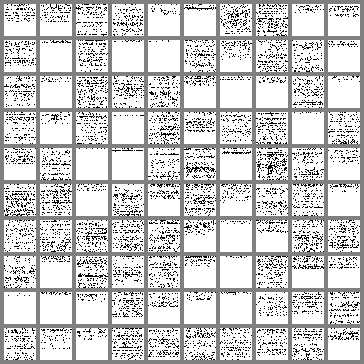

In [8]:
cols = 10
rows = 10
overview = PIL.Image.new('RGB', (cols * 36 + 4, rows * 36 + 4), (128, 128, 128))
for idx, icon in enumerate(generate_icons(model, num=cols * rows)):
    x = idx % cols
    y = idx // cols
    overview.paste(icon, (x * 36 + 4, y * 36 + 4))
overview
